# Methods for Data Science: Course Work 1

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('default')
from collections import defaultdict
np.random.seed(1234567)

## Task 1:  Regression (50 marks)



#### 1.1 Linear regression (8 marks)  

#### 1.1.1

Below I will train a Linear regression model on the data with loss
$$L(\beta) = \frac{1}{2N}||\mathbf{y}-\mathbf{X}\beta-\beta_{0}||^2$$
where $N$ is the size of the training set with training samples $\boldsymbol{X}$ and outcomes $\boldsymbol{y}$. From lectures, the least-squares solution is given by

$$\boldsymbol \beta_{*} = X^{+}y,$$
where $X^{+}$ is the Moore-Penrose inverse of $\boldsymbol X$. There exist many computational tools that can compute this pseudoinverse. Indeed, I will be using numpy's np.linalg.solve$(\cdot)$ function to compute the above.

In [2]:
def max_lik_estimate(X, y):
    
    # X: N x D matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: maximum likelihood parameters (D x 1)
    
    N, D = X.shape
    beta_ml = np.linalg.solve(X.T @ X, X.T @ y)
    return beta_ml

#### Training Set Generation

In [3]:
#Creating training and target data sets from given airfoil data
airfoil_data = pd.read_csv('airfoil_noise_samples.csv')
airfoil_target = np.array(airfoil_data['Sound Pressure'])#target variables
features = airfoil_data.columns[:-1]
airfoil_features = np.array(airfoil_data[features])#data set of predictor features for each airfoil
features_aug = np.concatenate((['offset'],features))

#### Test Set Genration

In [4]:
airfoil_test_data = pd.read_csv('airfoil_noise_test.csv')#reading airfoil test data
airfoil_test_target = np.array(airfoil_test_data['Sound Pressure'])#target variables
airfoil_test_features = np.array(airfoil_test_data[features])#data set of predictor features for each airfoil

N_test, D_test = airfoil_test_features.shape


#### Data Visualisation

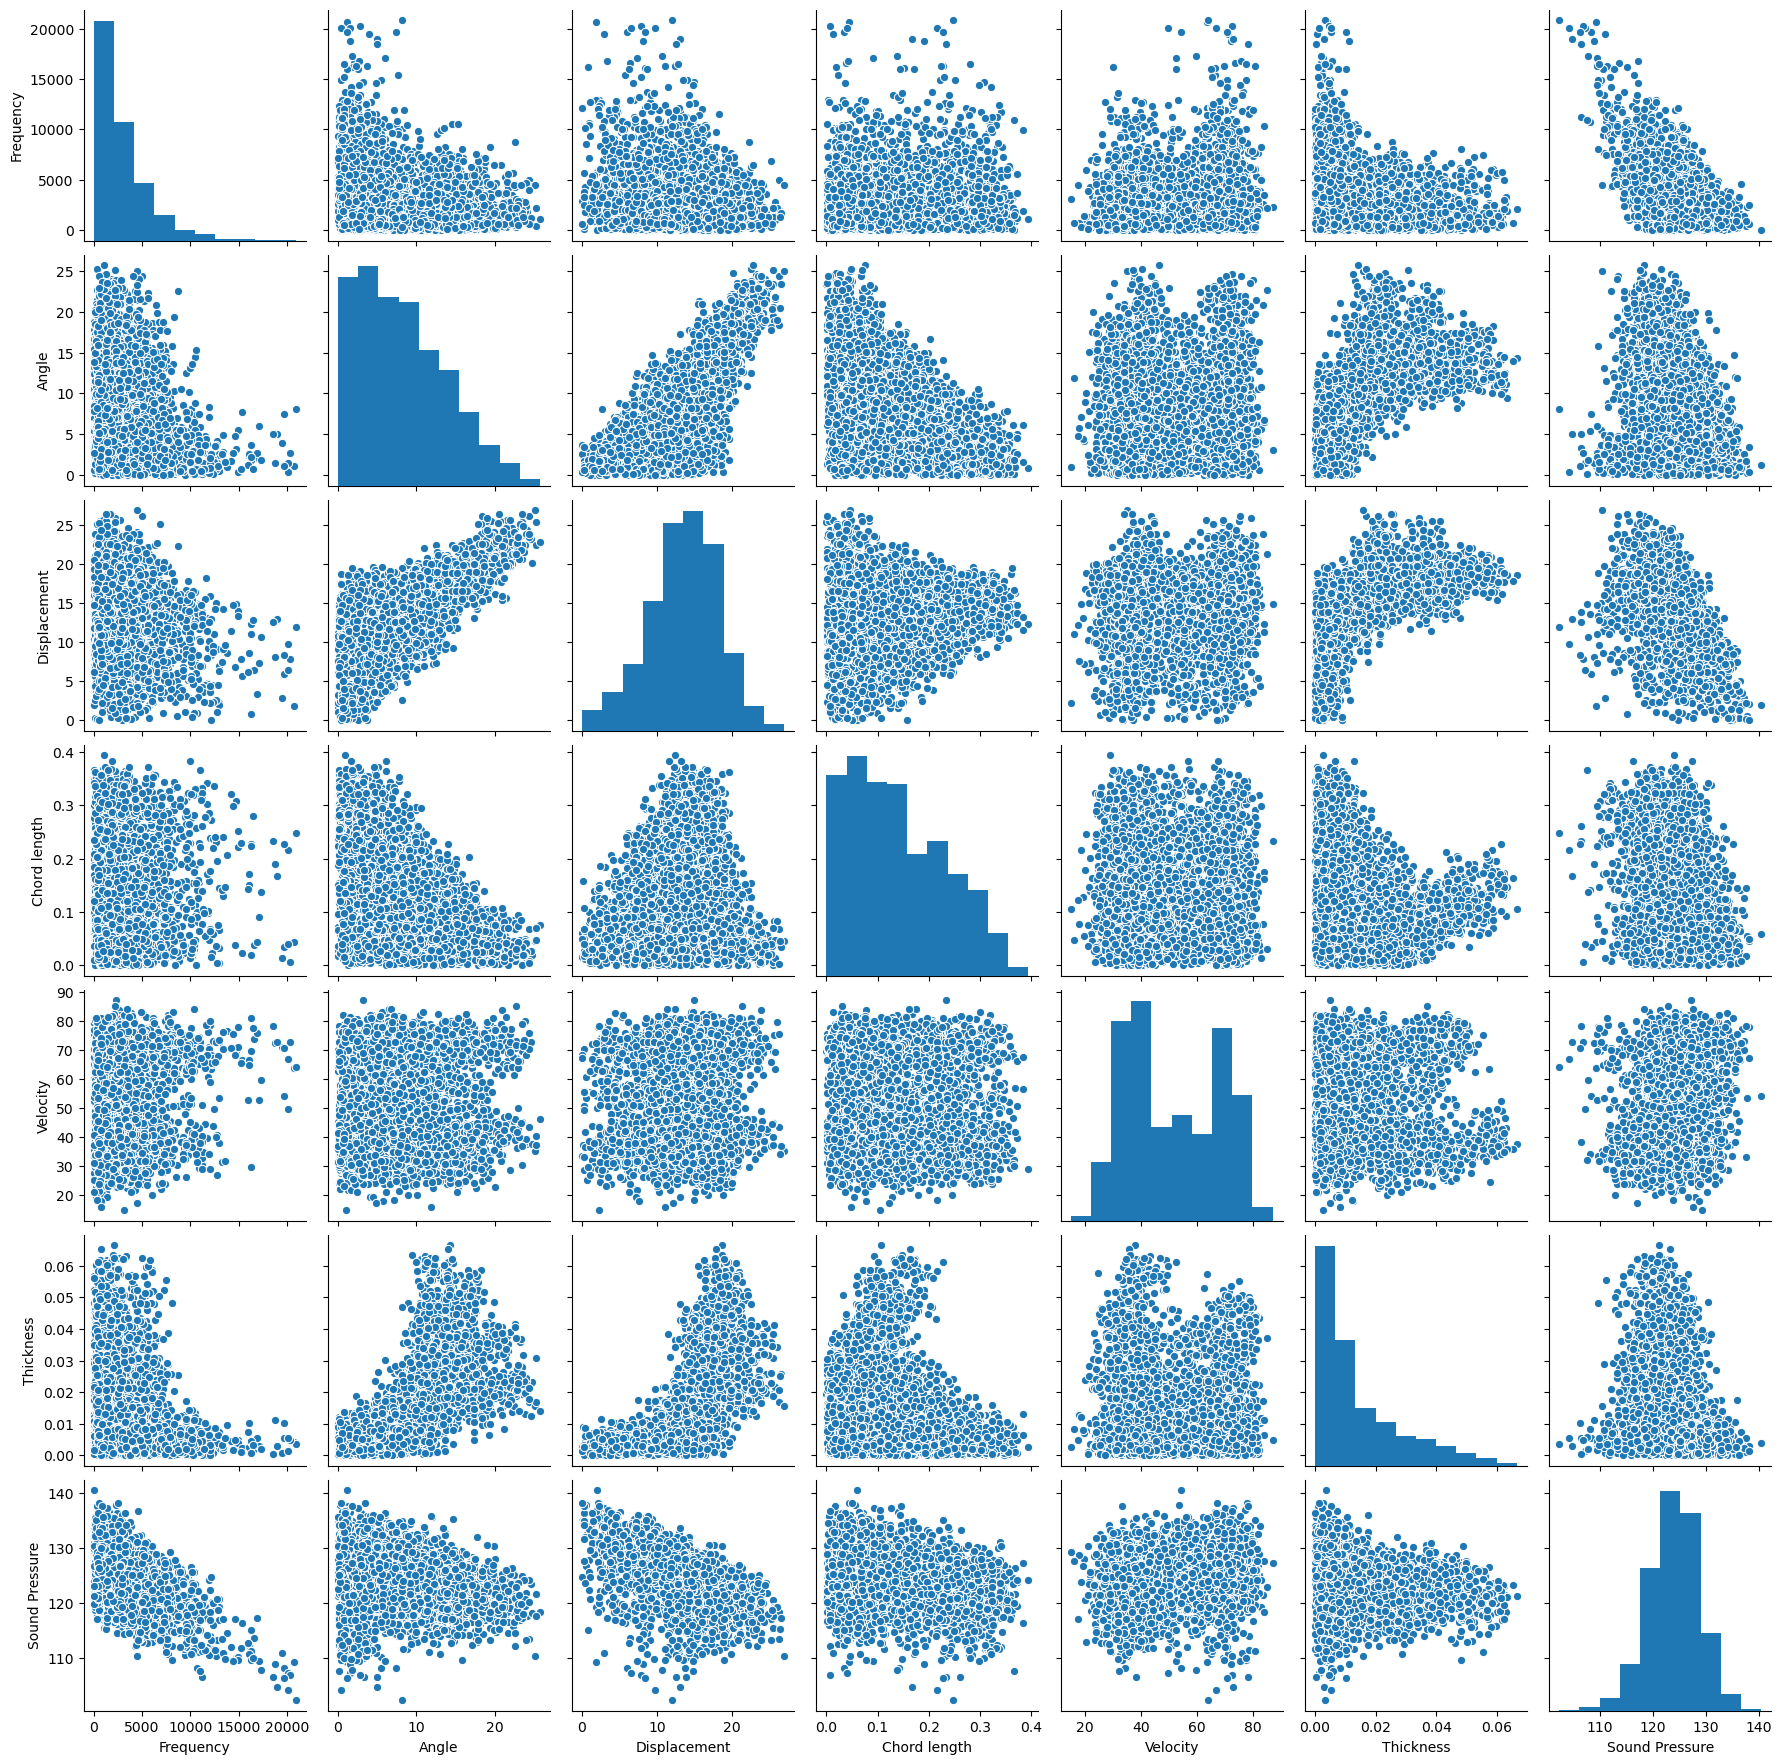

In [5]:
#pairplot of airfoil data
sns.pairplot(airfoil_data)

The condition number of a real invertivle matrix $A$ is given by:

$$
\kappa(A) = \left|\frac{\xi_{\text{max}}(A)}{\xi_{\text{min}}(A)}\right|
$$

where $\xi_{\text{max}}(A)$ and $\xi_{\text{min}}(A)$ denote the largest and smallest eigenvalues of $A$ respectively. Intuitively, very large $\kappa$ indicates that the matrix is computationally expensive to invert. 

Below we compute the condition numbers of the airfoil training data and see that by standardising, we reduce the condition number by two orders of magnitude. This means that standisation of the training and test data makes the problem better adapted to numerical optimisation algorithms such as gradient desent.

Computing the determinant of the matrix $X^T X$:

In [6]:
print(np.linalg.det(airfoil_features.T@airfoil_features))

1.630184753199732e+28


we see that it is non-zero, hence invertible. This means that the above discussion applies. Computing the condition number of $(X^TX)^{-1}$:

In [7]:
np.linalg.cond(np.linalg.inv(airfoil_features.T@airfoil_features))

169202124229.49283

In [8]:
#standardising dataset

def standardise(X_train, X_test):
    '''
    Arguments:
    X_train: (np.array) training set X_train
    X_test: (np.array) test set X_test
    
    Returns:
    X_std: (np.array) matrix with normalised entries based on the mean and variance of the columns of X_train
    '''
    mu = np.mean(X_train, 0)
    sigma = np.std(X_train, 0)
    X_std = (X_test - mu) / sigma 
    return X_std


In [9]:
#standardising the data:
airfoil_features_std = standardise(airfoil_features, airfoil_features)
np.linalg.cond(np.linalg.inv(airfoil_features_std.T@airfoil_features_std))

airfoil_test_features_std = standardise(airfoil_features, airfoil_test_features)


Thus, we see that standardisation of the training set reduces the condition number of $(X^T\cdot X)^{-1}$, where $X$ represents the airfoil features, i.e., the design matrix, by a factor of around $\frac{169202124229}{26}$, that is by $\sim 13$ orders of magnitude. From here, on, we aropt standardisation of the training and test data sets as it improves numerical performance and reduces the variance of our models, as was observed in the lecture notes.

In [10]:
#Standardising predictor training data for lienar regression 
airfoil_features_std = standardise(airfoil_features, airfoil_features)


In [11]:
#Augmenting the data to incorporate the offset 
N, D = airfoil_features_std.shape
airfoil_aug = np.hstack([np.ones((N,1)), airfoil_features_std]) # augmented training inputs of size N x (D+1)
airfoil_test_aug = np.hstack([np.ones((N_test,1)), airfoil_test_features_std]) # augmented training inputs of size N x (D+1)

In [12]:
def max_lik_estimate_aug(X_aug, y):
    
    #Computing maximum likelihood estimate for loss function
    
    beta_aug_ml = max_lik_estimate(X_aug, y) 
    
    return beta_aug_ml

Training the linear regression model with loss given above on the data 'airfoil_noise_samples.csv' gives the following parameters:

In [13]:
# inferred parameters of linear model
beta_aug_ml = max_lik_estimate_aug(airfoil_aug, airfoil_target)

$$\begin{aligned}
& \text {Table 1.1. In-sample predicted features }\\
&\begin{array}{ccccccc}
\hline \hline \text { Offset } & \text { Frequency } & \text { Angle } & \text { Displacement } & \text { Chord length }& \text { Velocity } & \text { Thickness }\\
\hline 1.23970283e+02& -3.57549693e+00&  8.34478004e-01& -3.92864721e+00&
      -7.83341979e-02&  1.72495668e+00& -1.35633979e-02\\
\hline
\end{array}
\end{aligned}$$

In [14]:
def predict_with_estimate(X_test, beta):
    '''
    Arguments:
    
    X_test: K x D matrix of test inputs
    beta: D x 1 vector of parameters
    
    Returns: 
    
    prediction: prediction of f(X_test); K x 1 vector
    
    '''
    
    prediction = X_test @ beta 
    
    return prediction 

In [15]:
airfoil_pred = predict_with_estimate(airfoil_aug,beta_aug_ml)#In-sample predicted values

The in-sample mean square error (MSE) of the dataset is given by: 
$$
MSE(y, \hat{y}) = \frac{\sum_{i=1}^N (y_i - \hat{y}_i)^2}{N} 
$$
Where the labels of the data set are called $y$ and the predictions thereof are $\hat{y}$.

In [16]:
def MSE(y_test, y_pred):
    
    return np.mean((y_test-y_pred)**2)

The $R^2$ score of the dataset is given by: 
$$
R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^N (y_i - \hat{y}_i)^2}{\sum_{i=1}^N (y_i - \bar{y})^2} \, ,
$$
where $\bar{y} = \frac{1}{N} \sum_{i=1}^N y_i$.
Where the labels of the data set are called $y$ and the predictions thereof are $\hat{y}$. Informally, it measures the fraction of the variance of the test data that is captured by model predictions thereof. That means that an $R^2$ score near $1$ indicates good model performance.

In [17]:
def r2_score(y_test, y_pred):
    #returns R squared score 
    numerator = np.sum((y_test - y_pred)**2) 
    y_avg = np.mean(y_test)
    denominator = np.sum((y_test - y_avg)**2)
    
    return 1 - numerator/denominator 

Comparing predicted values with actual values of the target feature (sound pressure) in the training set gives the following scores:

In [18]:
print(r'MSE for training data set:', MSE(airfoil_target, airfoil_pred))

MSE for training data set: 1.8755566396402008


In [19]:
print(r'R2 score for training data set:', r2_score(airfoil_target, airfoil_pred))

R2 score for training data set: 0.9177343977263077


#### 1.1.2

In [20]:
beta_aug_ml #Inferred parameters of lienar model trained on training set 'airfoil_noise_samples.csv'
airfoil_test_pred = predict_with_estimate(airfoil_test_aug, beta_aug_ml)#predicted values on test set

In [21]:
print(r'MSE for test data set:', MSE(airfoil_test_target, airfoil_test_pred))

MSE for test data set: 1.9843895771191515


In [22]:
print(r'R2 score for test data set:', r2_score(airfoil_test_target, airfoil_test_pred))

R2 score for test data set: 0.9083172459581625


In [23]:
np.mean(airfoil_target)# sample mean of target variable in 'airfoil_noise_samples.csv'

123.97028331480637

Comparing the out-of-sample and the
in-sample $R^{2}$ scores and MSE's:

$$\begin{aligned}
& \text {Table 1.1.2 Out-of-sample and
in-sample $R^{2}$ score and MSE for standard linear regression}\\
&\begin{array}{cc}
\hline \hline \text { Case } &  R^{2}  & \text { MSE } & {\hat{MSE}} \\
\hline \text{In-sample}& 0.9177343977263077&  1.8755566396402008 & 1.5129082466299357\%\\
       \text{Out-of-sample}&  0.9083172459581625& 1.9843895771191515 & 1.6006977834196383\%\\
\hline
\end{array}
\end{aligned}$$
where $\hat{MSE}$ is the MSE score as a percentage of the sample mean of target variable in 'airfoil_noise_samples.csv'. 

One observes from Table 1.2. that the out-of-sample $R^2$ score is less than the out of sample $R^2$ score for the in-sample set. Similarly, the out-of-sample MSE score is higher than the out-of-sample MSE score for the in-sample set.

It is expected that the model performance will be worse on unseen data due to overfitting. However, the out-of-sample scores, in particular the $R^2$ scores being above $0.9$ and the $\hat{MSE}$ scores being below $1.6\%$, means that the linear model generalises well to out-of-sample data. It further indicates that the linear model given an adequate relationship between the predictor and target variables.

#### 1.2 Lasso regression (12 marks) 

#### 1.2.1

In [24]:
from numpy import linalg as LA

We define the Lasso cost function below:
$$
L_{\text{LASSO}} = \frac{1}{2N}||\mathbf{y}-\mathbf{X}\beta-\beta_{0}||^2+\lambda\cdot||\beta||_{1}
$$

where $N$ is the size of the training set, $\boldsymbol{X}$ is the training data, $\boldsymbol{y}$ is the target variable and $\lambda$ is a non-negative regularisation parameter.

In [25]:
def Cost_LASSO(X, y, beta, beta_0, penalty):
    '''
    Arguments: 
    X: data samples of predictor variables; Nxd matrix
    y: vector of target variables corresponding to entries of X; Nx1 vector
    
    
    Returns: 
    cost: LASSO cost
    
    '''
    N, d = X.shape
    cost = (1/(2*N))*np.linalg.norm(y-beta_0*np.ones(N)-X@beta, ord = 2)**2 + penalty*np.linalg.norm(beta, ord = 1)
    return cost




The cost function $L_{\text{LASSO}}(\beta_0, \beta)$ is convex but not differentiable for $\beta = 0$. However, gradient descent is still doable using a subgradient thereof denoted $\nabla L_{\text{LASSO}}$. Since the function $|x|$ has  

$$\text{sign}(x) = 
\begin{cases}
1, \quad x>0\\
0, \quad x = 0\\
-1, \quad x < 0
\end{cases}
$$

as a subgradient. Thus, a routine computation yields:

$$
\frac{\partial L_{\text{LASSO}}}{\partial L_{\beta_0}} = -\frac{1}{N}\displaystyle\sum_{i=1}^N(y_i-\beta_0-X_i\beta)\\
\frac{\partial L_{\text{LASSO}}}{\partial L_{\beta_j}} = -\frac{1}{N}\displaystyle\sum_{i=1}^N(y_i-\beta_0-X_i\beta)X_{ij}+\lambda\cdot\text{sign}(\beta_j), \quad j = 1,\dots,d
$$

where $X_i$ denotes the $i$th row of the training data and $d$ the number of features (excluding the offset). With these gradients and the cost, one can conduct gradient descent and update the $\boldsymbol \beta$ and $\beta_0$ with a learning rate $\ell_r = \frac{1}{N_{\text{iterations}}}$ . I implement a gradient descent algorithm to minimise the cost function $L_{\text{LASSO}}$ using the following updating procedure for $\boldsymbol \beta$:
$$
\beta_j =  \beta_j - \ell_r \ \frac{\partial L_{\text{LASSO}}}{\partial  \beta_j},\quad  j = 1,\dots,d
$$
and for the offset $\beta_0$:
$$
\beta_0 = \beta_0 - \ell_r \ \frac{\partial L_{\text{LASSO}}}{\partial \beta_0}.
$$

with $\frac{\partial L_{\text{LASSO}}}{\partial \beta_0}$ and $\frac{\partial L_{\text{LASSO}}}{\partial  \beta_j}$ as computed as above.

We note that the parameter $\beta$ is initialised at the maximum likelihood estimate 'beta_aug_ml' obtained from Least Squares. This incorporates information about our previous best guess from Least Squares which should help guarantee the convergence of the gradient descent algorithm to the global minimum.

In [26]:
def propagate_LASSO(X, y, beta, beta_0, penalty):
    '''
    Arguments:
    X: data of size (n, d)
    y: true label vector of size (n, 1)
    beta: parameters, a numpy array of size (d, 1)
    beta_0: offset, a scalar

    Returns:
    cost: LASSO cost
    dbeta: gradient of the loss with respect to beta
    dbeta_0: gradient of the loss with respect to beta_0
    '''
    N, d = X.shape

    #compute cost
    cost = Cost_LASSO(X, y, beta, beta_0, penalty)

    # derivatives    
    dbeta_0 = -np.mean(y-beta_0*np.ones(N)-(X@beta), axis = 0)
    dbeta = -1/N*X.T@(y-beta_0*np.ones(N)-(X@beta)) + penalty*np.sign(beta)
    
    return cost, dbeta, dbeta_0

In [27]:
def optimise_LASSO(X, y, beta, beta_0, penalty, num_iterations = 2000, ϵ = 1e-6):
    '''
    Arguments:
    X: data of size (n, d)
    y: true label vector of size (n, 1)
    beta: parameters, a numpy array of size (d, 1)
    beta_0: offset, a scalar
    penalty: penalty hyper-parameter
    num_iterations: number of iterations gradient descent shall update the parameters
    ϵ: tolerance parameter; default value is set to 1e-4

    Returns:
    params: dictionary containing the parameters beta and offset beta_0
    grads: dictionary containing the gradients
    '''
    
    N,d = X.shape
    
    prev_cost = np.inf
    
    
    for i in range(num_iterations):
        
        learning_rate = 1/(i+1)
        # gradients/cost of Lasso cost function
        
        cost, dbeta, dbeta_0 = propagate_LASSO(X, y, beta, beta_0, penalty) 
        
        # updating procedure
        
        #stopping criterion, achieved when relative change in cost is within tolerance ϵ; checks convergence 
        if np.abs(prev_cost-cost)<ϵ*cost:
            beta, beta_0
            
        else:
            beta_0 = beta_0 - (learning_rate)*dbeta_0
    
            beta = beta - (learning_rate) * dbeta

            prev_cost = cost    
            
              
    return beta, beta_0

In [28]:
def model_LASSO(X_train, y_train, X_test, y_test, num_iterations = 2000, penalty = 0.5, features = False):
    '''
    Arguments:
    X_train: data of size (n, d)
    y_train: true label vector of size (n, 1)
    X_test: data of size (n, d)
    y_test: true label vector of size (n, 1)
    num_iterations: number of iterations gradient descent shall update the parameters
    penalty: penalty hyper-parameter
    features: flag variable; if true, return dictionary of model parameters and predictions, else return MSE

    Returns:
    params: return tuple containing the inferred parameters beta and offset beta_0
    MSE: MSE between predicted labels y_pred_train of the model trained on X_train\
    and true labels y_test 
    '''
    
    n,d = X_test.shape
    
    
    #parameters excluding offest are set to inferred model parameters from the regular linear regression
    beta = beta_aug_ml[1:]
    #offset initialised to sample mean of training data
    beta_0 = beta_aug_ml[0]
    
    # gradient descent
    beta, beta_0 = optimise_LASSO(X_train, y_train, beta, beta_0, penalty, num_iterations)
    
    # train set examples
    y_pred = X_test@beta+beta_0*np.ones(n)

    if features == True:
        return beta, beta_0
    
    else: 
    
        return  MSE(y_test, y_pred)

In [29]:
#Training and test airfoil data
X_train = standardise(airfoil_features, airfoil_features)
y_train = airfoil_target
X_test = standardise(airfoil_features, airfoil_test_features)
y_test = airfoil_test_target 

Now, by performing a grid-search, I will compute the optimal penalty hyper-parameter $\lambda$ by minimising the average MSE score obtained from a five-fold cross validation using the training set in 'airfoil_noise_samples.csv' (for a range of values of the learning-rate hyper-parameter $c$).

In [30]:
def cross_validation_score_LASSO(X_train, y_train, folds, num_iterations = 2000, penalty = 0.5, features = False):
    '''
    Arguments:
    X_train: data of size (n, d)
    y_train: true label vector of size (n, 1)
    folds: fold indices for train/validation data split
    num_iterations: number of iterations gradient descent shall update the parameters
    penalty: penalty hyper-parameter; non-negaitve float
    c: learning rate hyper-parameter
    features: if true, return dictionary of model parameters and predictions, else return MSE; boolean

    Returns:
    mean MSE score over 5-fold cross validation
    '''
    
    
    scores = []
    for i in range(len(folds)):
        
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))

        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]

        
        X_val_i = X_train[val_indexes, :] 
        y_val_i = y_train[val_indexes] 

        score_i = model_LASSO(X_train_i, y_train_i, X_val_i, y_val_i, num_iterations, penalty = penalty, features = features) 
        scores.append(score_i)
        

    # Return the average score
    return sum(scores) / len(scores) 

Searching Hyperparameter Space (i.e. $\lambda\geq 0$) for optimal penalty $\lambda$

In [31]:
#Training and test airfoil data
X_train = standardise(airfoil_features, airfoil_features)
y_train = airfoil_target
X_test = standardise(airfoil_features, airfoil_test_features)
y_test = airfoil_test_target 

In [32]:
# Compute a list of five index arrays, each correspond to one of the five folds.
folds_indexes = np.split(np.arange(len(airfoil_target)), 5)

I perform an initial rough grid search for 100 equally spaced values of $ \lambda $ from 0 to 1000 to roughly locate the optimal such penalty.

Text(0.5, 0, '$\\lambda$')

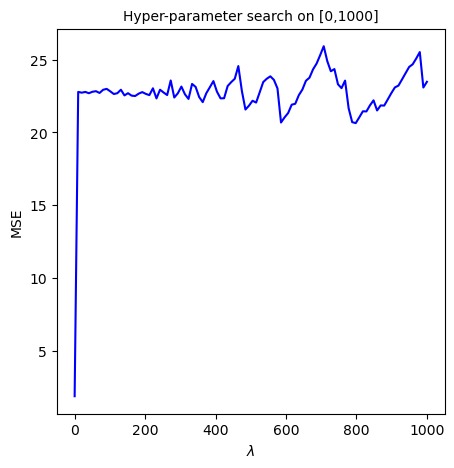

In [33]:
#Initial grid search to roughly locate the optimal lambda

x_rough = np.linspace(0, 1000, num = 100)
y_rough = [cross_validation_score_LASSO(X_train, y_train,  folds_indexes , num_iterations = 2000, penalty = penalty, features = False) for penalty in x_rough]
y_min_index_rough = np.array(y_rough).argmin()

plt.figure(figsize=(5, 5))
plt.title("Hyper-parameter search on [0,1000]", size=10)
plt.plot(x_rough, y_rough, 'b')
plt.ylabel('MSE', size=10)
plt.xlabel(r'$\lambda$', size=10)

I now narrow down the hyperparameter search to the intervals $1, 10$ and $0,0.1$ to further pin down the optimal hyperparameter value $\lambda_{\text{optimal}}$.

In [34]:
# values of hyperparameter to be searched: sampling at small and medium scales
x1 = np.linspace(0, 0.1, num = 50)
x2 = np.linspace(1, 10, num = 20)
y1 = [cross_validation_score_LASSO(X_train, y_train,  folds_indexes , num_iterations = 2000, penalty = penalty, features = False) for penalty in x1]
y2 = [cross_validation_score_LASSO(X_train, y_train,  folds_indexes , num_iterations = 2000, penalty = penalty, features = False) for penalty in x2]
y1_min_index = np.array(y1).argmin()
x1_min = x1[y1_min_index]
optimal_lambda_LASSO = x1[y1_min_index]

Text(0.5, 0, '$\\lambda$')

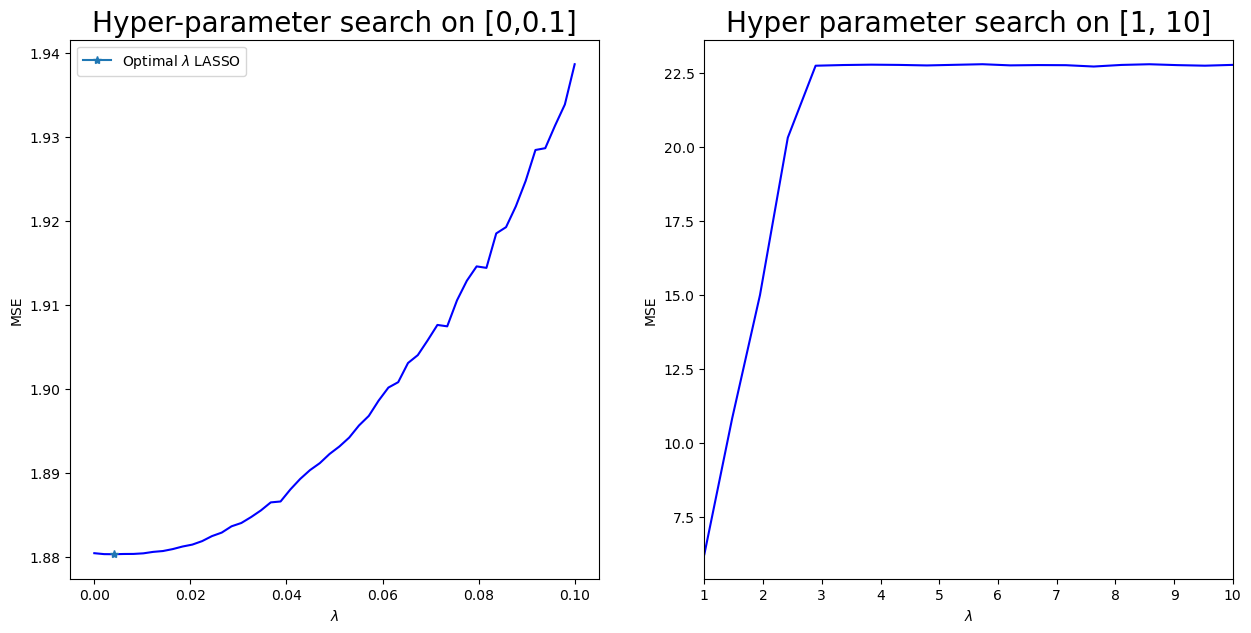

In [35]:
#plot scores for penalty hyper-parameter values
fig, axs = plt.subplots(1,2, figsize=(15, 7))
plt.style.use('default')


axs[0].set_title("Hyper-parameter search on [0,0.1]", size=20)
axs[0].plot(x1, y1, 'b')
axs[0].plot(x1_min, y1[y1_min_index], marker = "*", label = r'Optimal $\lambda$ LASSO')
axs[0].legend(loc='upper left')

axs[0].set_ylabel('MSE', size=10)
axs[0].set_xlabel(r'$\lambda$', size=10)

axs[1].set_title("Hyper parameter search on [1, 10]", size=20)
axs[1].plot(x2, y2, 'b')
axs[1].set_xlim([1, 10])
axs[1].set_ylabel('MSE', size=10)
axs[1].set_xlabel(r'$\lambda$', size=10)

In [36]:
#Optimal penalty for LASSO using grid search
print(f"Optimal penalty value: {optimal_lambda_LASSO}")

Optimal penalty value: 0.004081632653061225


#### 1.2.2

In [37]:
def plot_beta_LASSO(X_train, y_train, X_test, y_test, penalty_range, num_iterations = 2000):
    
    '''
    Arguments:
    X_train: train data of size (n, d)
    y_train: true train label vector of size (n, 1)
    X_test: test data of size (n, d)
    y_test: true test label vector of size (n, 1)
    penalty_range: array of penalty values
    num_iterations: number of iterations gradient descent shall update the parameters

    Returns:
    y: matrix where each row contains the model inferred parameters for a given penalty in penalty_range
    '''
    
    y = [model_LASSO(X_train, y_train, X_test, y_test, num_iterations = 2000, penalty = penalty, features = True)[0] for penalty in penalty_range]
    return np.array(y)


In [38]:
#Training/validation split

## stacking data X and labels y into one matrix
#standardise raw data
airfoil_data_std = airfoil_data
airfoil_data_std[features] = standardise(airfoil_data[features], airfoil_data[features])
airfoil_data_shuffle = airfoil_data_std.iloc[np.random.permutation(len(airfoil_data_std))]

# we split train to test as 70:30
split_rate = 0.7
train, test = np.split(airfoil_data_shuffle, [int(split_rate*(airfoil_data_shuffle.shape[0]))])

X_train_split = train[train.columns[:-1]]
y_train_split = train[train.columns[-1]]

X_test_split = test[test.columns[:-1]]
y_test_split = test[test.columns[-1]]

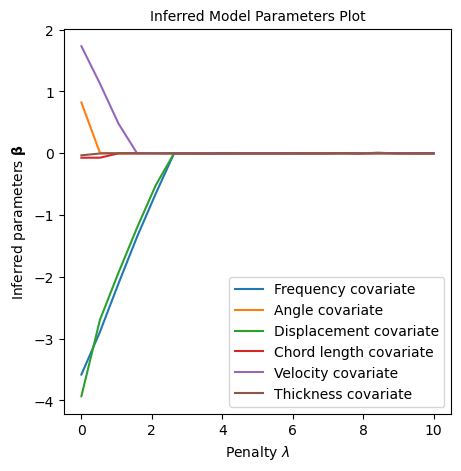

In [39]:
#plotting inferred parameters except the offset
penalty_range = np.linspace(0, 10, 20)


y = plot_beta_LASSO(X_train_split, y_train_split, X_test_split, y_test_split, penalty_range, num_iterations = 2000)

plt.figure(figsize = (5,5))
plt.style.use('default')

for i in range(y.shape[1]):
    plt.plot(penalty_range, y[:,i], label = features[i] + ' covariate')
    plt.title(f"Inferred Model Parameters Plot", size=10)
    plt.legend(loc = 'lower right')
    plt.ylabel(r'Inferred parameters $\bf{\beta}$', size=10)
    plt.xlabel(r'Penalty $\lambda$', size=10)

plt.show()

In the above plot, one can clearly see that all the inferred parameters that appear in the $L^1$ norm in $L_{\text{LASSO}}$, that is all but the offset, decay in absolute value to zero as the regularisation strength $\lambda$ increases. Furthermore, $\textbf{ sparsity}$ is achieved in the inferred parameters $\boldsymbol \beta$ as $\lambda$ increases as the angle, velocity and thickness covariates decay to zero in succession and faster than the rest and stay localised there. This can be explained by the geometry of the $L^1$ norm $||\boldsymbol\beta||_1$ as seen in lectures.

Also, note that from the lecture notes, the optimisation problem for LASSO is equivalent to the minimisation problem

$$ \displaystyle\min_{\boldsymbol\beta} L_{\text{LASSO}}(\boldsymbol \beta) \iff \displaystyle\min_{\boldsymbol\beta } ||y − X\boldsymbol\beta-\beta_0||^2, \quad 
\text{subject to } \quad ||\boldsymbol\beta||_1 \leq t 
$$

for some $t$ related to $\lambda$. It is expected that larger $\lambda$ values induce smaller values in $\boldsymbol\beta$ due to the bias-variance tradeoff.  $\textbf{ Shrinkage}$ reduces the variance of the model predictions, as the model parameters shrink to zero. This is because in the linear model we are considering, the model outputs depend linearly and hence continuously on the model parameters. This means that the least squares cost $\frac{1}{2N}||y − X\boldsymbol\beta-\beta_0||^2$ term approaches $\frac{1}{2N}||y -\beta_0||^2$, which is bounded from zero in general, being the half of the sample variance of the outcome variables $\boldsymbol y$. This is because the offset $\beta_0$ that minimises the loss is precisely the sample mean $ \bar{y}$. This is because the offset $\beta_0$ is not affected by the LASSO penalty term and its value that minimises the cost is simply the sample mean of the training data $\frac{1}{N}\boldsymbol y_{\text{train}}$.

#### 1.2.3

Using the optimal hyperparameters for $\lambda$, I compute the in-sample and out-of-sample MSE and $R^2$ scores for tha airfoil data.

In [40]:
#training linear model with LASSO loss for optimal parameter λ
beta_optimal_LASSO, beta_0_optimal_LASSO = model_LASSO(X_train, y_train, X_train, y_train, num_iterations = 2000,\
                penalty = optimal_lambda_LASSO,  features = True)
y_pred_LASSO = X_train@beta_optimal_LASSO+beta_0_optimal_LASSO*np.ones(X_train.shape[0])

y_pred_in_LASSO = X_train@beta_optimal_LASSO+beta_0_optimal_LASSO*np.ones(X_train.shape[0])

y_pred_out_LASSO = X_test@beta_optimal_LASSO+beta_0_optimal_LASSO*np.ones(X_test.shape[0])


In [41]:
print(f"MSE in sample: {MSE(y_train, y_pred_in_LASSO)}")
print(f"R2 in sample: {r2_score(y_train, y_pred_in_LASSO)}")

MSE in sample: 1.8756586326905673
R2 in sample: 0.9177299241105614


In [42]:
print(f"MSE out of sample: {MSE(y_test, y_pred_out_LASSO)}")
print(f"R2 out of sample: {r2_score(y_test, y_pred_out_LASSO)}")

MSE out of sample: 1.9825906409711131
R2 out of sample: 0.9084003603941077


The in-sample MSE score is smaller than the out-of-sample MSE score for the LASSO model with the optimal penalty as can be seen from the two cells above.  This means that model performance on unseen data is worse than on training data. This could be to increased bias of the model, since LASSO regression introduces shrinkage to the $\beta$s. Also, the $R^2$ score has fallen slightly by around $0.01$, meaning the model lost some of its ability to capture the variance of the unseen data, though minimal.

Now, we summarise the out-of-sample $R^{2}$ and MSE scores for standard linear regression and LASSO:


$$\begin{aligned}
& \text {Table 1.2.3 Out-of-sample $R^{2}$ and MSE scores for standard linear regression and LASSO}\\
&\begin{array}{cc}
\hline \hline  &  R^{2}  & \text { MSE } \\
\hline \text{Least-Squares } (\lambda = 0)& 0.9151497810118048&  1.9843895771191515\\
       \text{LASSO optimal}&   0.9084003603941077& 1.9825906409711131\\
\hline
\end{array}
\end{aligned}
$$

By observing table $1.2.3$, the least squares model has a better $R^2$ score, but a worse $MSE$. However, these differences seem to be rather small. Since the optimal value for $\lambda$ is of order $\sim 10^{-4}$, the models should have similar parameters. 

#### 1.3 Elastic Nets (20 marks) 
#### 1.3.1

We now consider a linear model that incorporates a compromise between Ridge and LASSO terms through the use of a parameter $\alpha\in [0,1]$. This aims to induce shrinkage in highly correlated factors, thereby rreaping the benefits of feature selection, such as lower model variance. 

Now, we define the Elastic net cost function below:
$$
L_{\text{EN}}(\beta) = \frac{1}{2N}||\mathbf{y}-\mathbf{X}\beta-\beta_{0}||^2+\lambda\cdot\alpha\cdot||\beta||_{1}
+ \lambda\cdot(1-\alpha)\cdot||\beta||_{2}^{2}
$$

where $N$ is the size of the training set, $\boldsymbol{X}$ is the training data, $\boldsymbol{y}$ is the target variable and $\lambda$ is a non-negative regularisation parameter. Furthermore, $\lambda$ controls the strength of the regularisation and $\alpha\in [0,1]$ controls the the relative
importance of the Ridge and Lasso terms
$\lambda\cdot(1-\alpha)\cdot||\beta||_{2}^{2}$ and $ \lambda\cdot\alpha\cdot||\beta||_{1}$ respectively. 

In [43]:
def Cost_EN(X, y, beta, beta_0, penalty, alpha):
    
    '''
    Arguments: 
    X: data samples of predictor variables; Nxd matrix
    y: vector of target variables corresponding to entries of X; Nx1 vector
    beta: feature weights vector
    penalty: strength regularisation term
    alpha: term that conrtols relative importance of Ridge and Lasso terms; float constrained in [0,1]
    
    Returns: 
    cost: EN cost
    
    '''
    N, d = X.shape
    
    return (1/(2*N))*LA.norm(y-beta_0*np.ones(N)-X@beta, ord = 2)**2 + penalty*(1-alpha)*LA.norm(beta, ord = 1) \
                + penalty*(1-alpha)*LA.norm(beta, ord = 2)


A routine computation gives the elastic net gradient:

$$
\frac{\partial L_{\text{EN}}}{\partial L_{\beta_0}} = -\frac{1}{N}\displaystyle\sum_{i=1}^N(y_i-\beta_0-X_i\beta)\\
\frac{\partial L_{\text{EN}}}{\partial L_{\beta_j}} = -\frac{1}{N}\displaystyle\sum_{i=1}^N(y_i-\beta_0-X_i\beta)X_{ij}+\lambda\cdot\alpha\cdot\text{sign}(\beta_j)+\lambda\cdot(1-\alpha)\cdot2\cdot\beta_j, \quad j = 1,\dots,d
$$

We note that the parameter $\beta$ is initialised at the maximum likelihood estimate 'beta_aug_ml' obtained from Least Squares as in the LASSO training step.

In [44]:
def propagate_EN(X, y, beta, beta_0, penalty, alpha):
    """
    Arguments:
    X: data of size (n, d)
    y: true label vector of size (n, 1)
    beta: parameters, a numpy array of size (d, 1)
    beta_0: offset, a scalar
    penalty: regularisation strength
    alpha: controls relative strength of Ridge/Lasso terms in EN cost

    Returns:
    cost: negative log-likelihood cost for logistic regression
    dbeta: gradient of the loss with respect to beta
    dbeta_0: gradient of the loss with respect to beta_0
    """
    
    N, d = X.shape
    
    #EN cost
    cost = Cost_EN(X, y, beta, beta_0, penalty, alpha)

    #beta_0 = np.mean(y)*np.ones(d)
    dbeta_0 = -np.mean(y-beta_0*np.ones(N)-(X@beta), axis = 0)
    dbeta =  -(1/N)*X.T@(y-beta_0*np.ones(N)-(X@beta)) + penalty*np.sign(beta) + 2*penalty*(1-alpha)*beta
    

    return cost, beta, beta_0, dbeta, dbeta_0

In [45]:
def optimise_EN(X, y, beta, beta_0, num_iterations, penalty, alpha):
    """
    Arguments:
    X: data of size (n, d)
    y: true label vector of size (n, 1)
    beta: parameters, a numpy array of size (d, 1)
    beta_0: offset, a scalar
    num_iterations: number of iterations gradient descent shall update the parameters
    penalty: regularisation strength
    alpha: controls relative strength of Ridge/Lasso terms in EN cost
    ϵ: tolerance parameter
    
    
    Returns:
    beta:inferred model parameters
    beta_0: offset
    """
    N,d = X.shape
    
    prev_cost = np.inf
    
    learning_rate = 1

    for i in range(num_iterations):
        
        # gradients of Lasso cost function
        cost, beta, beta_0, dbeta, dbeta_0 = propagate_EN(X, y, beta, beta_0, penalty, alpha) 


        # updating procedure
          
            
        beta_0 = beta_0 - (learning_rate)*dbeta_0

        beta = beta - (learning_rate) * dbeta

        prev_cost = cost

        learning_rate = 1/(i+1)

        

    return beta, beta_0

In [46]:
def model_EN(X_train, y_train, X_test, y_test, num_iterations, penalty = 1, alpha = 1, features = False):
    
    """
    Arguments:
    X_train: train data of size (n, d)
    y_train: true train label vector of size (n, 1)
    X_test: test data of size (n, d)
    y_test: true test label vector of size (n, 1)
    num_iterations: number of iterations gradient descent shall update the parameters
    penalty: regularisation strength
    alpha: controls relative strength of Ridge/Lasso terms in EN cost
    features: flag variable; if true, return dictionary of model parameters and predictions, else return MSE

    Returns:
    beta: inferred model parameters
    beta_0: offset
    """
    
    
    # initialize parameters
    n,d = X_test.shape
    #parameters excluding offest are set to inferred model parameters from the regular linear regression
    beta = beta_aug_ml[1:]
    #offset initialised to sample mean of training data
    beta_0 = beta_aug_ml[0]
    

    # gradient descent
    beta, beta_0 = optimise_EN(X_train, y_train, beta, beta_0, num_iterations, penalty, alpha)

    # retrieve parameters beta and beta_0 from dictionary "parameters"
    

    # train set examples
    y_pred = X_test@beta+beta_0*np.ones(n)

    # saving all information
    if features == True:
        return beta, beta_0
    
    return  MSE(y_test, y_pred)

#### 1.3.2

I wil perform a grid search on the hardness $\lambda$ for each values of $\alpha$ in $\{0.1, 0.5, 0.9\}$. 

In [47]:
def cross_validation_score_EN(X_train, y_train, folds, num_iterations, penalty = 0.5, alpha = 0):
    '''
    Arguments:
    X_train: data of size (n, d)
    y_train: true label vector of size (n, 1)
    folds: fold indices for train/validation data split
    num_iterations: number of iterations gradient descent shall update the parameters
    penalty: penalty hyper-parameter; non-negaitve float
    features: if true, return dictionary of model parameters and predictions, else return MSE; boolean

    Returns:
    mean EN MSE score over 5-fold cross validation
    '''
    '''
    #shuffle data
    p = np.random.permutation(len(y_train))
    X_train = X_train[p]
    y_train = y_train[p]
    '''
    
    
    scores = []
    
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))

        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]


        X_val_i = X_train[val_indexes, :] 
        y_val_i = y_train[val_indexes] 

        score_i = model_EN(X_train_i, y_train_i, X_val_i, y_val_i, num_iterations, penalty, alpha) 
        
        
        '''
        regr = ElasticNet(penalty, alpha, random_state=0)
        regr.fit(X_train_i, y_train_i)
        beta = regr.coef_
        beta_0 = regr.intercept_
        y_pred = X_val_i@beta+beta_0*np.ones(X_val_i.shape[0])
        score_i = MSE(y_val_i, y_pred)
        '''
        
        
        scores.append(score_i)

    # Return the average score
    return np.mean(scores)

In [48]:
def optimal_penalty_EN(X, y, penalty_range, alpha_vals, num_iterations = 2000):
    
    '''
    Arguments:
    X_train: data of size (n, d)
    y_train: true label vector of size (n, 1)
    penalty_range: grid of lambda hyper-parameter values
    alpha_vals: grid of alpha hyper-parametr values
    num_iterations: number of iterations gradient descent shall update the parameters

    Returns:
    optimal_lambdas: optimal lambda hyper-parameter values for each alpha in alpha_range; dictionary
    optimal_c: optimal learning rate hyper-parameter values for each alpha in alpha_range; dictionary
    '''

    optimal_lambdas = {alpha: 0 for alpha in alpha_vals}
    
    folds_indices =  np.split(np.arange(len(y)), 5)
    
    for alpha in alpha_vals:
        scores = np.zeros((len(penalty_range), len(c_range)))
        
        for i in range(len(penalty_range)):
               
            for k in range(len(c_range)):
                #shuffle data
                p = np.random.permutation(len(y))
                X_train = X[p]
                y_train = y[p]
                
                scores[i,k] = cross_validation_score_EN(X_train, y_train, folds_indices , num_iterations, \
                                    penalty = penalty_range[i], alpha = alpha)
                
                
                optimal_lambdas[alpha] = penalty_range[np.unravel_index(scores.argmin(), scores.shape)[0]]
                

        
    return optimal_lambdas

In [49]:
#Training and test airfoil data
X_train = standardise(airfoil_features, airfoil_features)
y_train = airfoil_target
X_test = standardise(airfoil_features, airfoil_test_features)
y_test = airfoil_test_target 

In [50]:
x = np.linspace(0, 0.005, num = 50)
folds_indices =  np.array_split(np.arange(len(y_train)), 5)

y1 = [cross_validation_score_EN(X_train, y_train, folds_indices, 2000, penalty, 0.1) for penalty in x]
y2 = [cross_validation_score_EN(X_train, y_train, folds_indices, 2000, penalty, 0.5) for penalty in x]
y3 = [cross_validation_score_EN(X_train, y_train, folds_indices, 2000, penalty, 0.9) for penalty in x]

In [51]:
#plotting MSE scores for α = 0, 1 too; used in 1.3.3 to plot inferred parameters
y4 = [cross_validation_score_EN(X_train, y_train, folds_indices, 2000, penalty, 0.0) for penalty in x]
x5 = np.linspace(0, 0.01, num = 50)
y5 = [cross_validation_score_EN(X_train, y_train, folds_indices, 2000, penalty, 1.0) for penalty in x5]

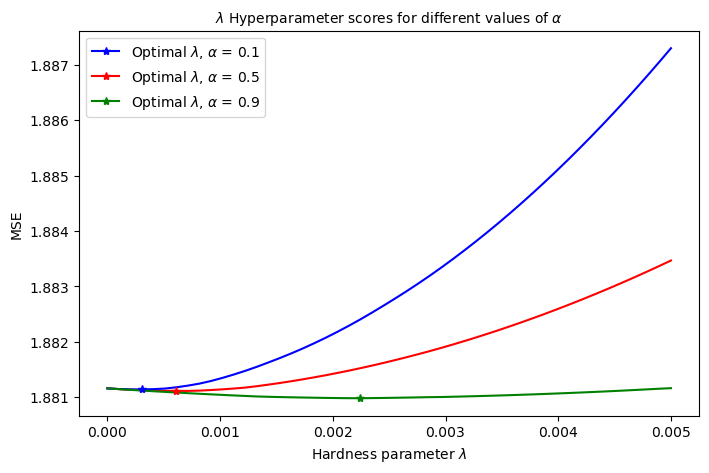

In [52]:
min_index_1 = np.array(y1).argmin()
min_index_2 = np.array(y2).argmin()
min_index_3 = np.array(y3).argmin()
min_index_4 = np.array(y4).argmin()
min_index_5 = np.array(y5).argmin()

indices_optimal = {0: min_index_1, 0.1: min_index_1, 0.5: min_index_2, 0.9: min_index_3, 1.0: min_index_5}


optimal_MSE_EN = {0.0: y4[min_index_4], 0.1: y1[min_index_1], 0.5: y2[min_index_2], 0.9: y3[min_index_3], 1.0: y5[min_index_5]}

plt.figure(figsize = (8, 5))
plt.plot(x,y2, c = 'r')
plt.plot(x,y1, c = 'b')
plt.plot(x,y3, c = 'g')
plt.plot(x[min_index_1], y1[min_index_1], marker = '*', c = 'b', label = r'Optimal $\lambda$, $\alpha$ = 0.1')
plt.plot(x[min_index_2], y2[min_index_2], marker = '*', c = 'r', label = r'Optimal $\lambda$, $\alpha$ = 0.5')
plt.plot(x[min_index_3], y3[min_index_3], marker = '*', c = 'g', label = r'Optimal $\lambda$, $\alpha$ = 0.9')
plt.title(r"$\lambda$ Hyperparameter scores for different values of $\alpha$", size = 10)
plt.xlabel(r"Hardness parameter $\lambda$", size = 10)
plt.ylabel("MSE", size = 10)

plt.legend()

In [53]:
#Optimal EN penalties
Optimal_penalties = []
x = np.linspace(0, 0.005, num = 50)
x5 = np.linspace(0, 0.01, num = 50)

alpha_vals = [0, 0.1, 0.5, 0.9, 1.0]
for alpha in alpha_vals[:-1]:
    Optimal_penalties.append(x[indices_optimal[alpha]])
    
Optimal_penalties.append(x5[indices_optimal[1]])

In [54]:
#Print optimal alphas
Alpha_vals = [0.1, 0.5, 0.9]
for alpha in Alpha_vals:
    
    #train model on optimal lambdas
    
    beta_optimal_EN, beta_0_optimal_EN = model_EN(X_train, y_train, X_train, y_train, num_iterations = 2000,\
                penalty = x[indices_optimal[alpha]],  alpha = alpha, features = True)

    y_pred_out_EN = X_test@beta_optimal_EN+beta_0_optimal_EN*np.ones(X_test.shape[0])

    # compute R^2 scores: 
    
    print(f'Optimal λ for α = {alpha} is: {x[indices_optimal[alpha]]}')
    print(f'Out-of-sample R2 score for α = {alpha} is: {r2_score(y_test, y_pred_out_EN)}')
    print(f'Out-of-sample MSE for α = {alpha} is: {MSE(y_test, y_pred_out_EN)}\n')

Optimal λ for α = 0.1 is: 0.0003061224489795918
Out-of-sample R2 score for α = 0.1 is: 0.9082934057430675
Out-of-sample MSE for α = 0.1 is: 1.9849055768275514

Optimal λ for α = 0.5 is: 0.0006122448979591836
Out-of-sample R2 score for α = 0.5 is: 0.9082940584822892
Out-of-sample MSE for α = 0.5 is: 1.9848914488825367

Optimal λ for α = 0.9 is: 0.0022448979591836735
Out-of-sample R2 score for α = 0.9 is: 0.9083222508551279
Out-of-sample MSE for α = 0.9 is: 1.984281250689865



We can thus conclude that $\alpha = 0.9$ gives the best model in the sense that it yields the minimal out-of-sample MSE score and the highest $R^2$ score out of the values of $\alpha$ above. To explain this, note that as $\alpha$ decreases to zero, there relative importance of the LASSO term in comparison to the Ridge term decreases to zero. This means that an elastic net model with such $\alpha$ will induce shrinkage on correlated variables without as much feature selection. 

#### 1.3.3

Text(0, 0.5, 'MSE')

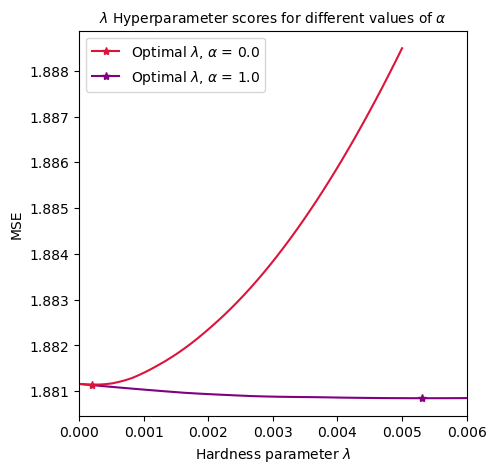

In [55]:
#Expanding the hyperparameter search for α = 1
plt.figure(figsize = (5,5))
plt.plot(x5, y5, c = 'purple')
plt.plot(x, y4, c = 'crimson')
plt.plot(x[min_index_4], y4[min_index_4], marker = '*', c = 'crimson', label = r'Optimal $\lambda$, $\alpha$ = 0.0')
plt.plot(x5[min_index_5], y5[min_index_5], marker = '*', c = 'purple', label = r'Optimal $\lambda$, $\alpha$ = 1.0')
plt.xlim([0,0.006])
plt.legend()
plt.title(r"$\lambda$ Hyperparameter scores for different values of $\alpha$", size = 10)
plt.xlabel(r"Hardness parameter $\lambda$", size = 10)
plt.ylabel("MSE", size = 10)

In [56]:
y = plot_beta_LASSO(X_train, y_train, X_test, y_test, Optimal_penalties, num_iterations = 2000)

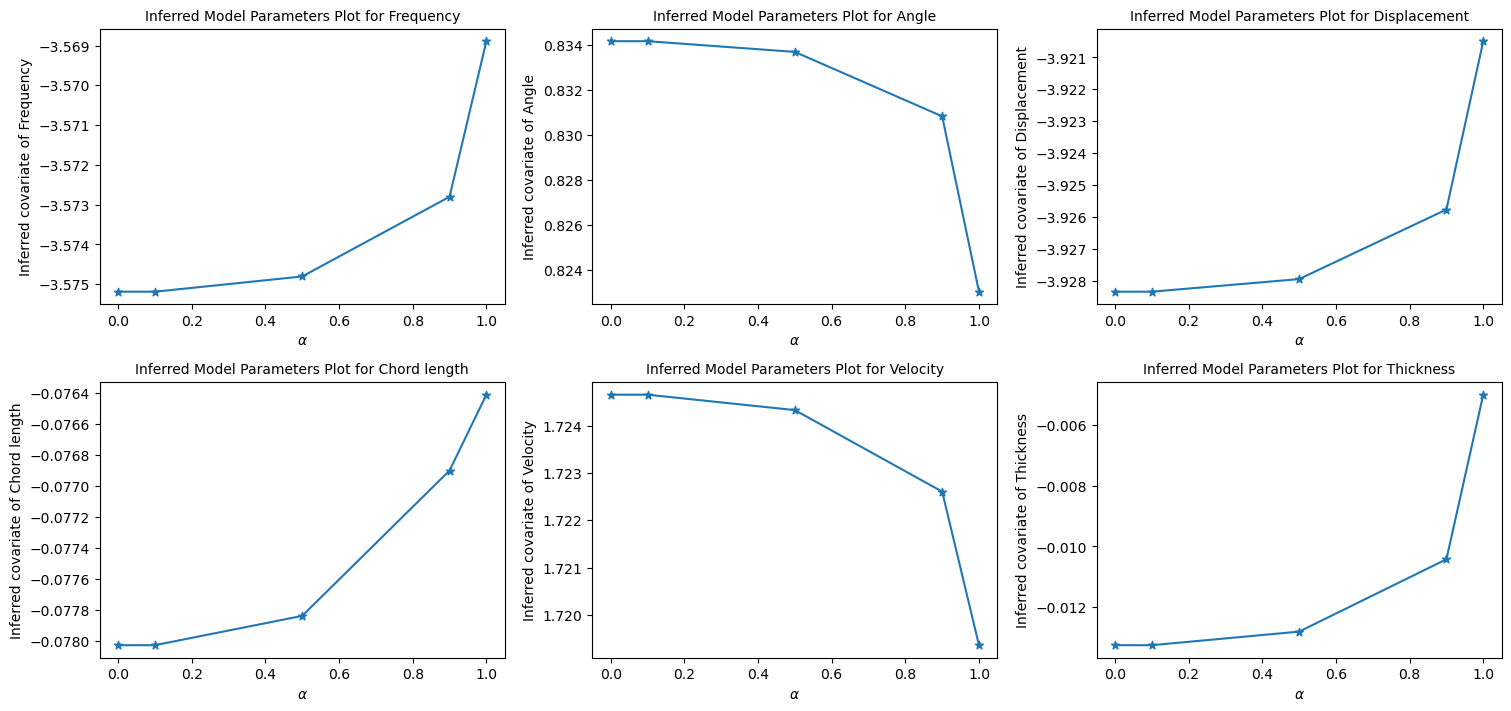

In [57]:
#Plotting inferred parameters for α in [0.0, 0.1, 0.5, 0.9, 1.0]:
#from colorspacious import cspace_converter

alpha_vals = [0, 0.1, 0.5, 0.9, 1.0]

fig, axs  = plt.subplots(2,3, figsize = (15,7), constrained_layout=True)

count = 0
for ind in range(2):
    for j in range(3):
        axs[ind, j].plot(alpha_vals, y[:,count], label = 'β '+str(count) )
        axs[ind, j].scatter(alpha_vals, y[:,count], marker = '*', label = features[count] + ' covariate')
        axs[ind, j].set_title(f"Inferred Model Parameters Plot for {features[count]}", size=10)
        axs[ind, j].set_ylabel(r'Inferred covariate of ' + features[count], size=10)
        axs[ind, j].set_xlabel(r'$\alpha$', size=10)
        count+=1

The case $\alpha = 0$ recovers Ridge regression, while the case $\alpha = 1$ recovers LASSO regression. Also note that the case $\alpha = 0.5$, one recovers an elastic net model with an even compromise between Ridge and LASSO. The shrinkage effect is accentuated the most in the LASSO case $\alpha = 1$, with the $\beta$ values being the least in absolute value. More generally, the shrinkage is monotone in $\alpha$, that is the higher the alpha, the grater the shrinkage effect on the model parameters $\beta$. The 'Angle' and 'Chord length' variables decay the fastest as $\alpha \to 1$, relative to to the other parameters. This highlights that the correlated parameters start to sparsify due to the increasing weight of LASSO regularisation. 

### 1.4 kNN regression (10 marks)
#### 1.4.1

In contrast to linear regression, the next model we will consider, namely the k-nearest neighbours is a $\textbf{lcoal}$ model where the predicted outocme variable depends on the input $\boldsymbol x_{\text{in}}$, rather than the entirety of the domain of inputs.

We note that due to there being no a priori diffrence in the relative importance of predictor variables, standardisation of the data set is crucial. For instance in the data set 'airfoil_features', the predictor variables (such as 'Angle' and 'Chord length') have different ranges. Clearly, the former will dominate the latter in Euclidean distance rendering normalisation of the range of the data necessary. 

In [58]:
def euclidian_distance(p, q):
    #returns: euclidean distance between arrays p,q
    return np.sqrt(np.sum((p-q)**2, axis=1)) 

In [59]:
def k_neighbours(X_train, X_test, k=5, return_distance=False):
    
    '''
    Arguments: 
    X_train: train data of size (n, d)
    X_test: test data of size (n,d)
    k: number of neighbours
    return_distance: if True, return distances together with indices of k nearest neighbours; boolean 
    
    Returns: array of k nearest neighbours 
    '''  
    
    n_neighbours = k
    dist = []
    neigh_ind = []

    # compute distance from each point x_test in X_test to all points in X_train 
    point_dist = [euclidian_distance(x_test, X_train) for x_test in X_test] 

    # determine which k training points are closest to each test point
    for row in point_dist:
        enum_neigh = enumerate(row)
        sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]

        ind_list = [tup[0] for tup in sorted_neigh]
        dist_list = [tup[1] for tup in sorted_neigh]

        dist.append(dist_list)
        neigh_ind.append(ind_list)

    # return distances together with indices of k nearest neighbours
    if return_distance:
        return np.array(dist), np.array(neigh_ind)

    return np.array(neigh_ind)

In [60]:
def reg_predict(X_train, y_train, X_test, k=20):
    # each of the k neighbours contributes equally to the classification of any data point in X_test  
    neighbours = k_neighbours(X_train, X_test, k=k)
    # compute mean over neighbours labels (hint: use python's list comprehension)
    y_pred = np.array([np.mean(y_train[neighbour]) for neighbour in neighbours]) 

    return y_pred

In [61]:
def score_kNN(X_train, y_train, X_test, y_test, k=5):
    y_pred = reg_predict(X_train, y_train, X_test, k=k) 
    return MSE(y_test, y_pred)

We now implement cross validation with shuffling for the k-nearest neighbours:

In [62]:
def cross_validation_score_kNN(X_train, y_train, folds, k):
    
    '''
    Arguments:
    X_train: data of size (n, d)
    y_train: true label vector of size (n, 1)
    k: number of neighbours

    Returns:
    mean MSE score over 5-fold cross validation
    '''
    
    N, d = X_train.shape
    p = np.random.permutation(len(y_train))
    X = X_train[p]
    y = y_train[p]
    
    scores = []
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))

        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]

        X_val_i = X_train[val_indexes, :] 
        y_val_i = y_train[val_indexes]

        score_i = score_kNN(X_train_i, y_train_i, X_val_i, y_val_i, k=k) 
        scores.append(score_i)
        
    # Return the average score
    return sum(scores) / len(scores) 

In [63]:
def choose_best_k(X_train, y_train, folds, k_range):
    
    '''
    Arguments:
    X_train: data of size (n, d)
    y_train: true label vector of size (n, 1)
    k_range: array of number of neighbours

    Returns:
    mean MSE score over 5-fold cross validation
    '''

    k_scores = np.zeros((len(k_range),))
  
    for i, k in enumerate(k_range):
        k_scores[i] = cross_validation_score_kNN(X_train, y_train, folds, k)
        print(f'CV_ACC@k={k}: {k_scores[i]:.3f}')

    best_k_index = np.argmin(k_scores)
    return k_range[best_k_index]

In [64]:
def k_scores(X_train, y_train, folds, k_range):
    
    '''
    Arguments:
    X_train: data of size (n, d)
    y_train: true label vector of size (n, 1)
    k_range: array of number of neighbours

    Returns: 
    k_scores: array of MSE scores for hyper-parameter values in k_range
    '''
    
    k_scores = np.zeros((len(k_range),))
  
    for i, k in enumerate(k_range):
        k_scores[i] = cross_validation_score_kNN(X_train, y_train, folds, k)

    return k_scores

We now train the KNN model for different values of the hyper-parameter k and compute the mean MSE scores resulting from a five-fold cross validation.

In [65]:
#Train KNN model with 5 fold cross-validation
folds_k = np.array_split(np.arange(len(y_train)), 5)
k_range = np.arange(1, 30)
K_scores = k_scores(X_train, y_train, folds_k, k_range)

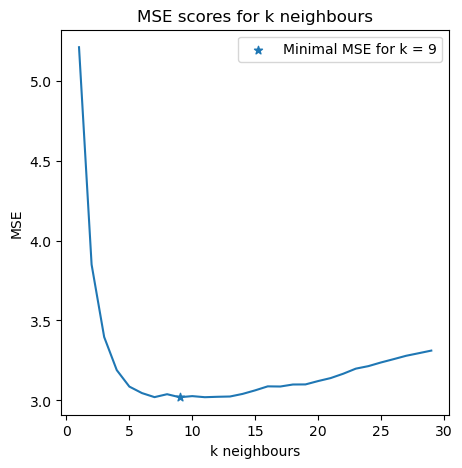

In [66]:
fig = plt.figure(figsize=(5,5))
plt.plot(k_range, K_scores)
minimal_k_index = np.array(K_scores).argmin()
plt.scatter(k_range[minimal_k_index], K_scores[minimal_k_index], marker = '*', label = f'Minimal MSE for k = {k_range[minimal_k_index]}')
plt.title("MSE scores for k neighbours")
plt.xlabel('k neighbours')
plt.ylabel('MSE')
plt.legend()

In [67]:
k_optimal = k_range[minimal_k_index]
print(f"Number of neighbours that minimises the MSE: {k_optimal}")

Number of neighbours that minimises the MSE: 9


Note that due to numerical precision being limited, we observe some variability in the optimal $k$, taking values from anywhere between 8 and 11.

#### 1.4.2

Training a KKN model using best value of the hyperparameter k $ = 9$ found above:

In [68]:
#out-of-sample MSE score
y_test_pred = reg_predict(X_train, y_train, X_test, k=k_optimal)
print(f"MSE out of sample: {MSE(y_test, y_test_pred)}")

MSE out of sample: 2.9835235358838124


Combining the out-of-sample MSE scores for all of the regression models considered thus far, with optimal hyper-parameters fine-tuned using grid searches and cross validation, we obtain:

$$\begin{aligned}
& 
&\begin{array}{cc}
\hline \hline  &\text { Least Squares } &  \text{LASSO}  & \text { Elastic Net } & \text{KNN}\\
\hline \text{Out-of-sample MSE scores} &1.9843895771191515  &  1.9825906409711131&  1.984281250689865 & 2.9835235358838124 \\
\hline
\end{array}
\end{aligned}\\
\text {Table 1.2. Comparing the out-of-sample  MSE scores }
$$


From the above, we conclude that the least MSE is given by the LASSO model of the data. The KNN model performs the worst. The pair plot below indicates that some features are correlated and exhibit linear relationships. This can be seen by considering the Displacement and Angle variables (plot below). By assuming a linear dependence between the variables, the linear models were better able to capture these trends, in comparisoin to the KKN model which assumes such prior relationship between predictor and outcome variables. Not to mention, being a non-parametric model, one cannot tune hyperparameters like that LASSO/Elastic net penalty to give better results.

Furthermore, since the LASSO model enforces sparsity, we conclude that the outcome variables are best described in terms of a linear model with feature selection.

Text(0, 0.5, 'Angle')

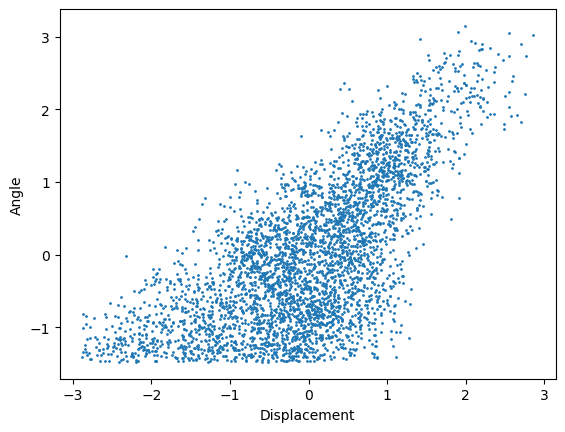

In [69]:
#Scatter plot between displacement and angle variables in the airfoil training data
plt.scatter(airfoil_data['Displacement'], airfoil_data['Angle'], s = 1)
plt.xlabel('Displacement')
plt.ylabel('Angle')

## Task 2: Classification  (50 marks)



I will also standardise the train and test data using the training set statistics for each predictor variable. This is not strictly necessary for classification tasks, but I will be consistent and it does not affect the results in any quantitative way.

#### 2.1 Random forest (20 marks)
#### 2.1.1

#### Training Set Geneartion

In [163]:
#diabetes train data
diabetes_data = pd.read_csv('diabetes_samples.csv')
N = diabetes_data.shape[0]
#replace commans in dataset by full-stops
diabetes_data['chol_hdl_ratio'] = [float(diabetes_data['chol_hdl_ratio'][i].replace(",", ".")) for i in range(N)]
diabetes_data['waist_hip_ratio'] = [float(diabetes_data['waist_hip_ratio'][i].replace(",", ".")) for i in range(N)]

diabetes_data['bmi'] = [float(diabetes_data['bmi'][i].replace(",", ".")) for i in range(N)]

diabetes_target = np.array(diabetes_data['diabetes'])#target variables

#Dropping patient number from dataset as it is not a predictor
diabetes_features = diabetes_data.columns[1:-1]
diabetes = diabetes_data[diabetes_features].to_numpy() #data set of predictor features for each airfoil



#diabetes test data
diabetes_test_data = pd.read_csv('diabetes_test.csv')
#replace commans in dataset by full-stops
diabetes_test_data['chol_hdl_ratio'] = [float(diabetes_test_data['chol_hdl_ratio'][i].replace(",", ".")) for i in range(len(diabetes_test_data))]
diabetes_test_data['waist_hip_ratio'] = [float(diabetes_test_data['waist_hip_ratio'][i].replace(",", ".")) for i in range(len(diabetes_test_data))]
diabetes_test_data['bmi'] = [float(diabetes_test_data['bmi'][i].replace(",", ".")) for i in range(len(diabetes_test_data))]

diabetes_test_target = np.array(diabetes_test_data['diabetes'])#target variables
diabetes_test = diabetes_test_data[diabetes_features].to_numpy() #data set of predictor features for each airfoil


#taking uniform training weights
training_weights = np.ones_like(diabetes_target) / len(diabetes_target)

# We need a dictionary indicating whether the column index maps to a 
# categorical feature or numerical
columns_dict = {index: False for index in range(len(diabetes_features))} # numerical features used so set to True in all columns

In [164]:
X_train = standardise(diabetes, diabetes)
y_train = diabetes_target
X_test = standardise(diabetes, diabetes_test)
y_test = diabetes_test_target

Below, we train a Random Forest model using cross-entropy as split criterion which selects the region that minimises the entropy:

$$
CE[\boldsymbol{\pi}(R_{\alpha})] = \displaystyle \sum_{q=1}^Q\pi_q(R_{\alpha})\cdot\log\pi_q(R_{\alpha})
$$
where 
$$
\pi_q(R_{\alpha}) = \frac{\displaystyle \sum_{n=1}^NI\{\boldsymbol{x}^{(i)}\in R_{\alpha}\land y^{(i)}\in c_q\}}{\sum_{n=1}^NI(\boldsymbol{x}^{(i)}\in R_{\alpha})}
$$

where $R_{\alpha}$ is a split region, $c_q$ denote a class label and the $\boldsymbol x$ and $\boldsymbol y$ denote predictor variables and outcome variables respectively. In brief, it is a measure of how much the empirical distribution of classes $\boldsymbol\pi(R_{\alpha})$ deviates from a uniform distribution.

In [165]:
def split_samples(X, y, sample_weights, column, value, categorical):
    """
    Return the split of data whose column-th feature:
    1. equals value, in case `column` is categorical, or
    2. less than value, in case `column` is not categorical (i.e. numerical)

    Arguments:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      column: the column of the feature for splitting.
      value: splitting threshold  the samples 
      categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
      tuple(np.array, np.array): tuple of subsets of X splitted based on column-th value.
      tuple(np.array, np.array): tuple of subsets of y splitted based on column-th value.
      tuple(np.array, np.array): tuple of subsets of sample weights based on column-th value.
    """ 

    if categorical:
        left_mask = (X[:, column] == value)
    else:
        left_mask = (X[:, column] < value)

    X_left, X_right = X[left_mask, :], X[~left_mask, :]
    y_left, y_right = y[left_mask], y[~left_mask]
    w_left, w_right  = sample_weights[left_mask], sample_weights[~left_mask]

    return (X_left, X_right), (y_left, y_right), (w_left, w_right)

In [166]:
def cross_entropy(y, sample_weights):
    """ 
    Calculates the cross entropy.
    Arguments:
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
    Returns:
      (float): the entropy for y.
    """

    # count different labels in y，and store in label_weights
    # initialize with zero for each distinct label.
    label_weights = {yi: 0 for yi in set(y)}  
    for yi, wi in zip(y, sample_weights):
        label_weights[yi] += wi

    total_weight = sum(label_weights.values())
    entropy = 0
    for label, weight in label_weights.items():
        p = weight/total_weight
        entropy -=  p*np.log(p)

    return entropy

In [167]:
def CE_split_value(X, y, sample_weights, column, categorical):
    """
    Calculate the cross-entropy based on `column` with the split that minimizes the cross-entropy.
    Arguments:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      column: the column of the feature for calculating. 0 <= column < D
      categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
      (float, float): the resulted GINI-index and the corresponding value used in splitting.
    """
  
    unique_vals = np.unique(X[:, column])

    assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Given: {unique_vals}."

    entropy_val, threshold = np.inf, None
  
    # split the values of i-th feature and calculate the cost 
    for value in unique_vals:
        (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, column, value, categorical) 
        # if one of the two sides is empty, skip this split.
        if len(y_l) == 0 or len(y_r) == 0:
            continue
    
        p_left = sum(w_l)/(sum(w_l) + sum(w_r))
        p_right = 1 - p_left
        
        new_cost = p_left*cross_entropy(y_l, w_l)+p_right*cross_entropy(y_r, w_r)
        if new_cost < entropy_val:
            entropy_val, threshold = new_cost, value

    return entropy_val, threshold

In [168]:
# evaluate for feature sepal width (cm)
CE_split_value(X_train, y_train, training_weights, 3, columns_dict[3])

(0.40091974976607536, 1.532326516835744)

In [169]:
def CE_split(X, y, sample_weights, columns_dict):
    """
    Choose the best feature to split according to criterion.
    Args:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
      (int, float): the best feature index and value used in splitting. 
      If the feature index is None, then no valid split for the current Node.
    """

    # Initialize `split_column` to None, so if None returned this means there is no valid split at the current node.
    min_CE_index, split_column, split_val = np.inf, None, 0
    for column, categorical in columns_dict.items():
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue
        CE_index, val = CE_split_value(X, y, sample_weights, column, categorical)  
        if CE_index < min_CE_index:
            min_CE_index, split_column, split_val = CE_index, column, val

    return split_column, split_val

In [170]:
# evaluate which feature is best
CE_split(X_train, y_train, training_weights, columns_dict)

(1, 0.16413058018367138)

In [171]:
def majority_vote(y, sample_weights):
    """
    Return the label which appears the most in y.
    Args:
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
    Returns:
      (int): the majority label
    """
    majority_label = {yi: 0 for yi in set(y)}

    for yi, wi in zip(y, sample_weights):
        majority_label[yi] += wi
                
    return max(majority_label, key=majority_label.get)

In [172]:
def build_tree(X, y, sample_weights, columns_dict, feature_names, depth,  max_depth=10, min_samples_leaf=1):
    """Build the decision tree according to the data.
    Args:
      X: (np.array) training features, of shape (N, D).
      y: (np.array) vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
      feature_names (list): record the name of features in X in the original dataset.
      depth (int): current depth for this node.
    Returns:
      (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
        1. 'feature_name': The column name of the split.
        2. 'feature_index': The column index of the split.
        3. 'value': The value used for the split.
        4. 'categorical': indicator for categorical/numerical variables.
        5. 'majority_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
        6. 'left': The left sub-tree with the same structure.
        7. 'right' The right sub-tree with the same structure.
      Example:
          mytree = {
              'feature_name': 'petal length (cm)',
              'feature_index': 2,
              'value': 3.0,
              'categorical': False,
              'majority_label': None,
              'left': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
              'right': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
          }
    """
    # include a clause for the cases where (i) no feature, (ii) all labels are the same, (iii) depth exceed, or (iv) X is too small
    if len(np.unique(y))==1 or depth>=max_depth or len(X)<=min_samples_leaf: 
        return {'majority_label': majority_vote(y, sample_weights)}

    split_index, split_val = CE_split(X, y, sample_weights, columns_dict)  


    # If no valid split at this node, use majority vote.
    if split_index is None:
        return {'majority_label': majority_vote(y, sample_weights)}

    categorical = columns_dict[split_index]
    (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, split_index, split_val, categorical) 
    return {
      'feature_name': feature_names[split_index],
      'feature_index': split_index,
      'value': split_val,
      'categorical': categorical,
      'majority_label': None,
      'left': build_tree(X_l, y_l, w_l, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
      'right': build_tree(X_r, y_r, w_r, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf)
    }

We now implement the classification algorithm for the decision tree model that we will use to construct a random forest.

In [173]:
def classify(tree, x):
    """
    Classify a single sample with the fitted decision tree.
    Args:
      x: ((np.array) a single sample features, of shape (D,).
    Returns:
      (int): predicted testing sample label.
    """
    if tree['majority_label'] is not None: 
        return tree['majority_label']

    elif tree['categorical']:
        if x[tree['feature_index']] == tree['value']:
            return classify(tree['left'], x)
        else:
            return classify(tree['right'], x)

    else:
        if x[tree['feature_index']] < tree['value']:
            return classify(tree['left'], x)
        else:
            return classify(tree['right'], x)

In [174]:
def predict(tree, X):
    """
    Predict classification results for X.
    Args:
      X: (np.array) testing sample features, of shape (N, D).
    Returns:
      (np.array): predicted testing sample labels, of shape (N,).
    """
    if len(X.shape) == 1:
        return classify(tree, X)
    else:
        return np.array([classify(tree, x) for x in X])

In [175]:
def tree_score(tree, X_test, y_test):
    y_pred = predict(tree, X_test) 
    return np.mean(y_pred==y_test)

In [176]:
def train(X, y, feature_names, columns_dict, sample_weights=None):
    """
    Build the decision tree according to the training data.
    Args:
      X: (numpy.ndarray) training features, of shape (N, D). Each X[i] is a training sample.
      y: (numpy.array) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] <= C. Here C = 1.
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
      sample_weights: weights for each samples, of shape (N,).
    """
    depth = 1
    if sample_weights is None:
      # if the sample weights is not provided, we assume the samples have uniform weights
      sample_weights = np.ones(X.shape[0]) / X.shape[0]
    else:
        sample_weights = np.array(sample_weights) / np.sum(sample_weights)

    
    return build_tree(X, y, sample_weights, columns_dict, feature_names, depth)

In [177]:
# fit the decision tree with training data
tree = train(X_train, y_train, diabetes_features, columns_dict)

In [178]:
print('Training accuracy:', tree_score(tree, X_train, y_train))
print('Test accuracy:', tree_score(tree, X_test, y_test))

Training accuracy: 1.0
Test accuracy: 0.9230769230769231


#### Random Forest Implementation

In [179]:
def CE_split_rf(n_features, X, y, sample_weights, columns_dict):
    """
    Choose the best feature to split according to criterion.
    Args:
      n_features: number of sampled features.
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
      (float, int, float): the minimized cross entropy value, the best feature index and value used in splitting.
    """
    columns = np.random.choice(list(columns_dict.keys()), n_features, replace=False)
    columns_dict = {c: columns_dict[c] for c in columns}

    min_entropy_index, split_column, split_val = np.inf, 0, 0
    for column, categorical in columns_dict.items():
    # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue
        # search for the best splitting value for the given column.
        entropy_index, val = CE_split_value(X, y, sample_weights, column, categorical)    
        if entropy_index < min_entropy_index:
            min_entropy_index, split_column, split_val = entropy_index, column, val

    return min_entropy_index, split_column, split_val

In [180]:
def build_tree_rf(n_features, X, y, sample_weights, columns_dict, feature_names, depth=1,  max_depth=10, min_samples_leaf=1):
    """Build the decision tree according to the data.
    Args:
      X: (np.array) training features, of shape (N, D).
      y: (np.array) vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
      feature_names (list): record the name of features in X in the original dataset.
      depth (int): current depth for this node.
    Returns:
      (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
        1. 'feature_name': The column name of the split.
        2. 'feature_index': The column index of the split.
        3. 'value': The value used for the split.
        4. 'categorical': indicator for categorical/numerical variables.
        5. 'majority_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
        6. 'left': The left sub-tree with the same structure.
        7. 'right' The right sub-tree with the same structure.
      Example:
          mytree = {
              'feature_name': 'petal length (cm)',
              'feature_index': 2,
              'value': 3.0,
              'categorical': False,
              'majority_label': None,
              'left': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
              'right': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
          }
    """
    
    # include a clause for the cases where (i) all lables are the same, (ii) depth exceed (iii) X is too small
    if len(np.unique(y)) == 1 or depth>=max_depth or len(X)<=min_samples_leaf: 
        return {'majority_label': majority_vote(y, sample_weights)}

    else:
        CE, split_index, split_val = CE_split_rf(n_features, X, y, sample_weights, columns_dict)  

        # If CE is infinity, it means that samples are not seperable by the sampled features.
        if CE == np.inf:
            return {'majority_label': majority_vote(y, sample_weights)}
        categorical = columns_dict[split_index]
        (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, split_index, split_val, categorical) 
        return {
            'feature_name': feature_names[split_index],
            'feature_index': split_index,
            'value': split_val,
            'categorical': categorical,
            'majority_label': None,
            'left': build_tree_rf(n_features, X_l, y_l,  w_l, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
            'right': build_tree_rf(n_features, X_r, y_r, w_r, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf)
        }

In [181]:
def train_rf(B, n_features, X, y, columns_dict, feature_names, bootstrap_distribution, sample_weights = None, max_depth = 10):
    """
    Build the decision tree according to the training data.
    Args:
      B: number of decision trees.
      X: (np.array) training features, of shape (N, D). Each X[i] is a training sample.
      y: (np.array) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] <= C. Here C = 1.
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
      sample_weights: weights for each samples, of shape (N,).
    """
    if sample_weights is None:
      # if the sample weights is not provided, we assume the samples have uniform weights
        sample_weights = np.ones(X.shape[0]) / X.shape[0]
    else:
        sample_weights = np.array(sample_weights) / np.sum(sample_weights)

    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []    
    
    bootstrap_weights = np.ones(len(y))/len(y)
        
    # if bootstrap_distribution is set to True, change bootstrap weights to balance class sampling frequencies

    if bootstrap_distribution is True:
        def compute_sample_weights(y_train):
            diabetes_count = len(np.where(y_train == 'Diabetes')[0])
            non_diabetes_count = len(np.where(y_train == 'No diabetes')[0])
            weight_non_diabetes = 1/(2*non_diabetes_count)
            weight_diabetes = 1/(2*diabetes_count)

            training_weights_unbalanced =  np.zeros(len(y_train))

            for i in range(len(y_train)):
                if i in np.where(y_train == 'No diabetes')[0]:
                    training_weights_unbalanced[i] = weight_non_diabetes
                else:
                    training_weights_unbalanced[i] = weight_diabetes
            return training_weights_unbalanced

        bootstrap_weights = compute_sample_weights(y)

    for _ in range(B):
        sample =  np.random.choice(training_indices, N, p = bootstrap_weights, replace = True)
        X_sample = X[sample, :]
        y_sample = y[sample]
        w_sample = sample_weights[sample]
        tree = build_tree_rf(n_features, X_sample, y_sample, w_sample, columns_dict, feature_names, max_depth = max_depth)
        trees.append(tree)
       

    return trees

In [182]:
def predict_rf(rf, X):
    """
    Predict classification results for X.
    Args:
      rf: A trained random forest through train_rf function.
      X: (pd.Dataframe) testing sample features, of shape (N, D).
    Returns:
      (np.array): predicted testing sample labels, of shape (N,).
    """

    def aggregate(decisions):
        count = defaultdict(int)
        for decision in decisions:
            count[decision] += 1
        return max(count, key=count.get)

    if len(X.shape) == 1:
        return aggregate([classify(tree, X) for tree in rf])
    else:
        return np.array([aggregate([classify(tree, x) for tree in rf]) for x in X])

In [183]:
def rf_score(B, n_features, X_train, y_train, X_test, y_test, bootstrap_distribution = False, sample_weights = None, max_depth = 10):
    """Compute mean accuracy score of model on test data X_test, y_test
    Args:
      B: (int) number of trees in random forest
      n_features: (int) number of features selected at random at each split
      X_train: (np.array) training features, of shape (N, D).
      y_train: (np.array) vector of training labels, of shape (N,).
      X_test: (np.array) test features, of shape (N', D).
      y_test: (np.array) vector of test labels, of shape (N',).
      folds: (np.array) array of indices for each training/validation split in cross validation
      bootstrap_distribution: if True, use weighted bootstrap_weights to evenly select samples of both classes when creating each tree\
                  else, use standard bootstrap weights, i.e. uniform ones.
      sample_weights: weights for each samples, of shape (N,).

      feature_names (np.array): record the name of features in X in the original dataset.
      max_depth (int): maximum possible depth for each tree in random forest.
    Returns:
      mean accuracy score of model on test data

    """
    
    
    rf = train_rf(B, n_features, X_train, y_train, columns_dict, diabetes_features,\
                  bootstrap_distribution, sample_weights = sample_weights, max_depth = max_depth)
    y_pred = predict_rf(rf, X_test) 
    return np.mean(y_pred==y_test)

Cross validation with four folds

In [184]:
def cross_validation_score_rf(B, n_features, X_train, y_train, folds, sample_weights = None, bootstrap_distribution = False, max_depth = 10):
    
    """Build the decision tree according to the data.
    Args:
      B: (int) number of trees in random forest
      n_features: (int) number of features selected at random at each split
      X: (np.array) training features, of shape (N, D).
      y: (np.array) vector of training labels, of shape (N,).
      folds: (np.array) array of indices for each training/validation split in cross validation
      sample_weights: weights for each samples, of shape (N,).
      bootstrap_distribution: if True, use weighted bootstrap_weights to evenly select samples of both classes when creating each tree\
                  else, use standard bootstrap weights, i.e. uniform ones
      feature_names (np.array): record the name of features in X in the original dataset.
      max_depth (int): maximum possible depth for each tree in random forest.
    Returns:
      mean validation score of model on training data

    """
    
    scores = []
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))

        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]
        

        X_val_i = X_train[val_indexes, :] 
        y_val_i = y_train[val_indexes]
        
        
        # if bootstrap_distribution is set to True, change bootstrap weights to balance class sampling frequencies
        
    
        score_i = rf_score(B, n_features, X_train_i, y_train_i, X_val_i, y_val_i,\
                           bootstrap_distribution = bootstrap_distribution, sample_weights = sample_weights , max_depth = max_depth) 
        scores.append(score_i)
        
    # Return the average score
    return sum(scores) / len(scores) 

Below I perform a grid search on: 

(i) number of decision trees;
(ii) depth of decision trees

with mean accuracy as the measure of performance for this hyper-parameter optimisation. From lecture notes, B number of trees is best kept at a small range as it convergese quickly and the max depth of the trees should also be kept relatively small to prevent overfitting of the training data.

In [209]:
# creating grid for tuning the hyperparameters above

B = np.arange(1,20,2)
max_depth = np.arange(1,20,2)

n_features = int(np.sqrt(X_train.shape[1]))

#define folds
folds_rf = np.array_split(np.arange(len(y_train)), 4)

scores_rf = np.zeros((len(B), len(max_depth)))

for i in range(len(B)):
    for j in range(len(max_depth)):
        #shuffling data
        N, d = X_train.shape
        p = np.random.permutation(len(y_train))
        X = X_train[p]
        y = y_train[p]

        scores_rf[i][j] = cross_validation_score_rf(B[i], n_features,\
                                                           X, y, folds_rf, max_depth =  max_depth[j]) 

In [210]:
B_optimal_standard = B[np.unravel_index(scores_rf.argmax(), scores_rf.shape)[0]]
max_depth_optimal_standard = max_depth[np.unravel_index(scores_rf.argmax(), scores_rf.shape)[1]]

In [211]:
#Optimal Parameters
print(f"Optimal number of decision trees: {B_optimal_standard}")
print(f"Optimal depth of decision trees: {max_depth_optimal_standard}")

Optimal number of decision trees: 15
Optimal depth of decision trees: 13


#### 2.1.2

In [212]:
#Training model on optimal hyperparameters
rf_optimal = train_rf(B_optimal_standard, n_features, X_train, y_train, columns_dict,\
                      diabetes_features, sample_weights=None, bootstrap_distribution = False, max_depth = max_depth_optimal_standard)

For this binary classification task, the classifications of the random forest model on data can be succintly presented in a $\textbf{confusion matrix}$, namely: 



$$\begin{aligned}
& \text {Table 2.1 Confusion Matrix}\\
&\begin{array}{cc}
\hline \hline & \text{Diabetes}  & \text { Non-diabetes } \\
\hline \text{Diabetes} & \text{True Positives (TP)}&  \text{False Positives (FP)} \\
       \text{Non-diabetes}&\text{False Negatives} (FN) & \text{True Negatives (TN)} \\
\hline
\end{array}
\end{aligned}$$

The following quality measures will be used to quantify model performance on data based on the entries in table $2.1$ above:



$$\text{Accuracy} = \frac{TP+TN}{N_{\text{validation}}}$$

$$ \text{Precision} = \frac{TP}{TP+FP}$$

$$\text{Recall} = \frac{TP}{TP+FN}$$

$$ \text{F score } = 2  \frac{\text{precision} \cdot\text{recall}}{\text{precision} + \text{recall}}$$

where $N_{\text{validation}} = TP+TN+FN+FP$.

In [213]:
#precision and recall functions
def TNR_rf(y_test, y_pred):
    TP = len(np.where((y_pred == 'Diabetes') & (y_test == 'Diabetes'))[0])
    FN = len(np.where((y_pred == 'No diabetes') & (y_test == 'Diabetes'))[0])
    FP = len(np.where((y_pred == 'Diabetes') & (y_test == 'No diabetes'))[0])
    TN = len(np.where((y_pred == 'No diabetes') & (y_test == 'No diabetes'))[0])
    N_val = TP+TN+FP+FN
    if (TN) == 0 & TN+FP == 0:
        return 'No information'
    else: 
        return (TN)/(TN+FP)

In [214]:
def recall_rf(y_test, y_pred):
    TP = len(np.where((y_pred == 'Diabetes') & (y_test == 'Diabetes'))[0])
    FN = len(np.where((y_pred == 'No diabetes') & (y_test == 'Diabetes'))[0])
    FP = len(np.where((y_pred == 'Diabetes') & (y_test == 'No diabetes'))[0])
    TN = len(np.where((y_pred == 'No diabetes') & (y_test == 'No diabetes'))[0])
    N_val = TP+TN+FP+FN
    if (TP) == 0 & TP+FN == 0:
        return 'No information'
    else: 
        return (TP)/(TP+FN)

In [215]:
def precision_rf(y_test, y_pred):
    TP = len(np.where((y_pred == 'Diabetes') & (y_test == 'Diabetes'))[0])
    FN = len(np.where((y_pred == 'No diabetes') & (y_test == 'Diabetes'))[0])
    FP = len(np.where((y_pred == 'Diabetes') & (y_test == 'No diabetes'))[0])
    TN = len(np.where((y_pred == 'No diabetes') & (y_test == 'No diabetes'))[0])
    N_val = TP+TN+FP+FN
    if (TP) == 0 & TP+FP == 0:
        return 'No information'
    else: 
        return (TP)/(TP+FP)


In [216]:
def accuracy_rf(y_test, y_pred):
    TP = len(np.where((y_pred == 'Diabetes') & (y_test == 'Diabetes'))[0])
    FN = len(np.where((y_pred == 'No diabetes') & (y_test == 'Diabetes'))[0])
    FP = len(np.where((y_pred == 'Diabetes') & (y_test == 'No diabetes'))[0])
    TN = len(np.where((y_pred == 'No diabetes') & (y_test == 'No diabetes'))[0])
    N_val = TP+TN+FP+FN
    return (TP+TN)/N_val

In [217]:
def F_score_rf(y_test, y_pred):
    precision = precision_rf(y_test, y_pred) 
    recall = recall_rf(y_test, y_pred) 
    
    if precision == 'No information' or recall == 'No information':
        return 0
    else:
        return 2*precision*recall/(precision+recall)

In [218]:
#performance against test data
y_pred_standard_bootsatrap = predict_rf(rf_optimal, X_test) 
np.mean(y_pred_standard_bootsatrap==y_test)

0.9316239316239316

In [219]:
#Computing Accuracy, precision and F score for standard bootstrap
print(f"Accuracy: {accuracy_rf(y_test, y_pred_standard_bootsatrap)}")
print(f"Precision: {precision_rf(y_test, y_pred_standard_bootsatrap)}")
print(f"F score: {F_score_rf(y_test, y_pred_standard_bootsatrap)}")

Accuracy: 0.9316239316239316
Precision: 0.8333333333333334
F score: 0.7142857142857143


The out-of-sample accuracy score is high and the out-of-sample precision and F scores are noticeably smaller. The F score being the smallest means that the out of sample recall and precision of the model are not balanced. Since  precision and F score do not depend on true negatives, while the accuracy does, this means indicates that the model is rather good at predicting the majority class but performs less well when for classificaiton of the  minority, that is the diabetes outcomes.

#### 2.1.3

Computing frequencieis of diagnostic outcomes:

In [220]:
diabetes_count = len(np.where(y_train == 'Diabetes')[0])
non_diabetes_count = len(np.where(y_train == 'No diabetes')[0])

print(f"Proportion of outcomes non-diabetic patients: {non_diabetes_count/len(y_train)}")

Proportion of outcomes non-diabetic patients: 0.8388278388278388


This shows that the training set is indeed unbalanced in favour of non-diabetic patients. This is a problem for medical practitioners or anyone interested in using this model. This is because misclassification of the former is  penalised the same as misclassification of non-diabetic people. This may lead to misleadingly high accuracy and AUC scores.

In [221]:
#retraining random forest using new (unbalanced) weights
B = np.arange(1,20,2)
max_depth = np.arange(1,20,2)
N, d = X_train.shape

grid_pred_params = np.zeros((len(B), len(max_depth)))

for i in range(len(B)):
    for j in range(len(max_depth)):
        
        #shuffling data
        p = np.random.permutation(len(y_train))
        X_train = X_train[p]
        y_train = y_train[p]
        grid_pred_params[i][j] = cross_validation_score_rf(B[i], n_features, X_train, y_train, folds_rf, max_depth =  max_depth[j], sample_weights = None, bootstrap_distribution = True) 



In [222]:
B_optimal_unbalanced = B[np.unravel_index(grid_pred_params.argmax(), grid_pred_params.shape)[0]]
max_depth_unbalanced = max_depth[np.unravel_index(grid_pred_params.argmax(), grid_pred_params.shape)[1]]

In [223]:
#Optimal Parameters
print(f"Optimal number of decision trees: {B_optimal_unbalanced}")
print(f"Optimal depth of decision trees: {max_depth_unbalanced}")

Optimal number of decision trees: 17
Optimal depth of decision trees: 11


In [224]:
def roc_curve(y_true, y_pred):
    """
    Arguments:
    y_true: ground truth labels with size (N, )
    y_preds: probabilities produced by random forest model (N, )

    Returns:
    auc: area under the curve (AUC).
    tpr_l: a list of true positive rate (TPR) values for each scanned threshold.
    fpr_l: a list of false positive rate (FPR) values for each scanned threshold.
    thresholds: the scanned thresholds sorted descendingly.
    """
        

    # List of distinct values in y_pred, sorted descendingly.
    thresholds = reversed(sorted(set(y_pred)))
    tpr_l, fpr_l, precision_l = [], [], []

    for threshold in thresholds:
        # Apply thresholding

        y_thresholded = (y_pred >= threshold)

        # true positives
        tp = np.sum(y_true & y_thresholded)
        # true negatives
        tn = np.sum((~y_true) & (~y_thresholded))
        # false positives
        fp = np.sum((~y_true) & y_thresholded)
        # false negatives
        fn = np.sum(y_true & (~y_thresholded))

        tpr = tp / (tp + fn) 
        fpr = fp / (tn + fp)
        precision = tp/ (tp + fp)
        
        tpr_l.append(tpr)
        fpr_l.append(fpr)
        precision_l.append(precision)

    # Compute AUC using Trapezoidal rule
    auc = np.trapz(tpr_l, fpr_l)
    
    return auc, tpr_l, fpr_l, precision_l

In [225]:
def success_probability(decisions, classes):
    """
    Arguments:
    decisions: classifications of each tree in random forest on test data
    classes: class labels

    Returns: probability assigned by random forest model of having diabetes
    """ 
    count = {Class: 0 for Class in set(classes)}
    
    for decision in decisions:
        count[decision] += 1

    return count['Diabetes']/len(decisions)

In [226]:
#mapping arrays to boolean
def diabetes_boolean_rf(y):
    n = len(y)
    a = np.zeros(n)
    for i in range(n):
        if y[i] == 'Diabetes':
            a[i] = 1 
        else:
            a[i] = 0
    return np.array([int(element) for element in a])

In [227]:
n_features = int(np.sqrt(X_train.shape[1]))
y_train_boolean_rf = diabetes_boolean_rf(y_train)
y_test_boolean_rf = diabetes_boolean_rf(y_test)
classes = ['Diabetes', 'No diabetes']

In [228]:
# unbalanced weights
B = B_optimal_standard
max_depth = max_depth_optimal_standard

rf_unbalanced  = train_rf(B, n_features, X_train, y_train, columns_dict, diabetes_features,\
              sample_weights = None, bootstrap_distribution = True, max_depth = max_depth)

y_rf_ensemble_votes_unbalanced_in = np.array([success_probability([classify(tree, x) for tree in rf_unbalanced], classes) for x in X_train])

y_rf_ensemble_votes_unbalanced_out = np.array([success_probability([classify(tree, x) for tree in rf_unbalanced], classes) for x in X_test])

In [229]:
#uniform weights
B_nw = B_optimal_unbalanced
max_depth_nw = max_depth_unbalanced


rf_no_weights  = train_rf(B_nw, n_features, X_train, y_train, columns_dict, diabetes_features,\
              sample_weights = None, bootstrap_distribution = False, max_depth = max_depth_nw)

y_rf_ensemble_votes_in_nw = np.array([success_probability([classify(tree, x) for tree in rf_no_weights], classes) for x in X_train])
y_rf_ensemble_votes_out_nw = np.array([success_probability([classify(tree, x) for tree in rf_no_weights], classes) for x in X_test])

In [230]:
#In sample scores

auc_in_unbalanced, tpr_in_unbalanced,\
fpr_in_unbalanced, precision_in_unbalanced = roc_curve(y_train_boolean_rf, y_rf_ensemble_votes_unbalanced_in)
auc_nw_in, tpr_nw_in, fpr_nw_in,\
precision_nw_in = roc_curve(y_train_boolean_rf, y_rf_ensemble_votes_in_nw)

In [231]:
#Out of sample scores
auc_out_unbalanced, tpr_out_unbalanced,\
fpr_out_unbalanced, precision_out_unbalanced = roc_curve(y_test_boolean_rf, y_rf_ensemble_votes_unbalanced_out)
auc_nw_out, tpr_nw_out, fpr_nw_out,\
precision_nw_out = roc_curve(y_test_boolean_rf, y_rf_ensemble_votes_out_nw)

Text(0.5, 0, 'Recall')

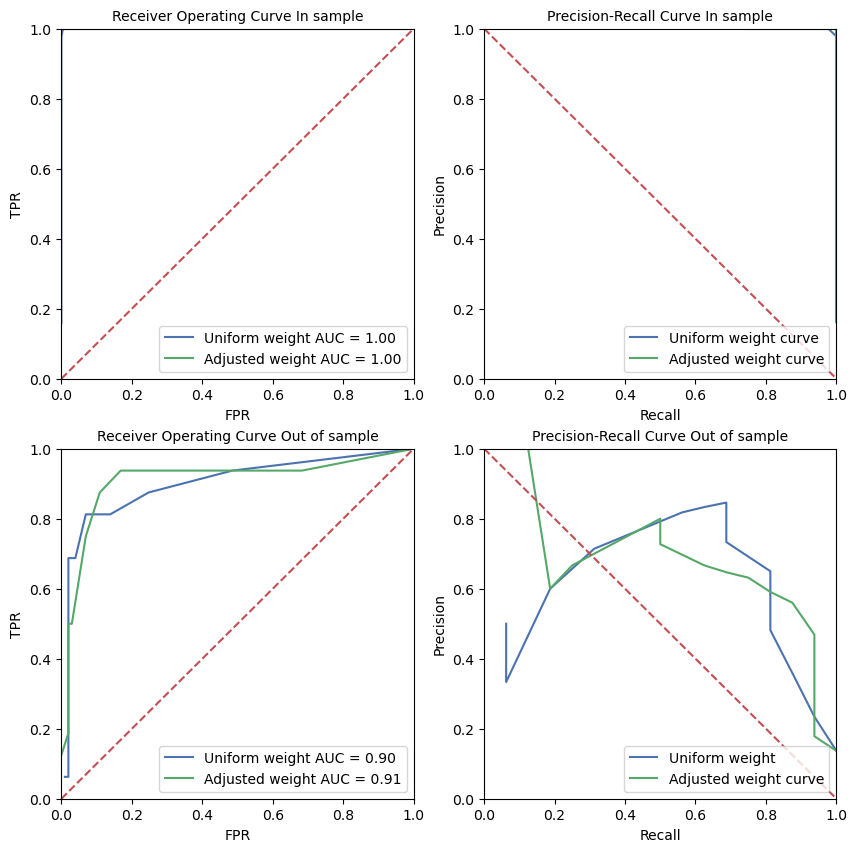

In [232]:
#plot ROC and precision-recall curves
fig, axs = plt.subplots(2,2, figsize=(10, 10))
axs[0,0].set_title(f"Receiver Operating Curve In sample", size=10)
axs[0,0].plot(fpr_nw_in, tpr_nw_in, 'b', label = f'Uniform weight AUC = {auc_nw_in:0.2f}')
axs[0,0].plot(fpr_in_unbalanced, tpr_in_unbalanced, 'g', label = f'Adjusted weight AUC = {auc_in_unbalanced:0.2f}')
axs[0,0].legend(loc = 'lower right')

axs[0,0].plot([0, 1], [0, 1],'r--')
axs[0,0].set_xlim([0, 1])
axs[0,0].set_ylim([0, 1])
axs[0,0].set_ylabel('TPR', size=10)
axs[0,0].set_xlabel('FPR', size=10)

axs[0,1].set_title(f"Precision-Recall Curve In sample", size=10)
axs[0,1].plot(tpr_nw_in, precision_nw_in, 'b', label = f'Uniform weight curve')
axs[0,1].plot(tpr_in_unbalanced, precision_in_unbalanced, 'g', label = f'Adjusted weight curve')
axs[0,1].legend(loc = 'lower right')

axs[0,1].plot([0, 1], [1, 0],'r--')
axs[0,1].set_xlim([0, 1])
axs[0,1].set_ylim([0, 1])
axs[0,1].set_ylabel('Precision', size=10)
axs[0,1].set_xlabel('Recall', size=10)

axs[1,0].set_title(f"Receiver Operating Curve Out of sample", size=10)
axs[1,0].plot(fpr_nw_out, tpr_nw_out, 'b', label = f'Uniform weight AUC = {auc_nw_out:0.2f}')
axs[1,0].plot(fpr_out_unbalanced, tpr_out_unbalanced, 'g', label = f'Adjusted weight AUC = {auc_out_unbalanced:0.2f}')
axs[1,0].legend(loc = 'lower right')

axs[1,0].plot([0, 1], [0, 1],'r--')
axs[1,0].set_xlim([0, 1])
axs[1,0].set_ylim([0, 1])
axs[1,0].set_ylabel('TPR', size=10)
axs[1,0].set_xlabel('FPR', size=10)

axs[1,1].set_title(f"Precision-Recall Curve Out of sample", size=10)
axs[1,1].plot(tpr_nw_out, precision_nw_out, 'b', label = f'Uniform weight')
axs[1,1].plot(tpr_out_unbalanced, precision_out_unbalanced, 'g', label = f'Adjusted weight curve')
axs[1,1].legend(loc = 'lower right')

axs[1,1].plot([0, 1], [1, 0],'r--')
axs[1,1].set_xlim([0, 1])
axs[1,1].set_ylim([0, 1])
axs[1,1].set_ylabel('Precision', size=10)
axs[1,1].set_xlabel('Recall', size=10)



The in sample curves indicate near perfect model performance, which is not too surprising, as the roc curves are at the top-left and the precision-recall curves at the top right.

The above plots show that weighted bootstrap random forest show a better out of sample AUC of 0.91 than standard bootstrap's AUC of 0.90. Also, the precision-recall curve of the weighted bootstrap random forest (green) is above and to the right, indicating improved recall and precision scores than the standard bootsrtap curve (blue). 

This is expected as the purpose of choosing a weighted bootrstap distribution is to ensure a good performance
in this imbalanced cases. By both under-sampling the majority of the class and over-
sampling the minority class, misclasification of the minority class is penalised more. This leads to a model with an improved true positive rate, recall and precision scores, as they roughly measure the model's ability to correctly classify the minority class, i.e. 'diabetes'.

#### 2.2	Support Vector Machine (SVM) (30 marks)
#### 2.2.1

In [116]:
#diabetes train data
diabetes_data = pd.read_csv('diabetes_samples.csv')
N = diabetes_data.shape[0]
#replace commans in dataset by full-stops
diabetes_data['chol_hdl_ratio'] = [float(diabetes_data['chol_hdl_ratio'][i].replace(",", ".")) for i in range(N)]
diabetes_data['waist_hip_ratio'] = [float(diabetes_data['waist_hip_ratio'][i].replace(",", ".")) for i in range(N)]
diabetes_data['bmi'] = [float(diabetes_data['bmi'][i].replace(",", ".")) for i in range(N)]

diabetes_target = np.array(diabetes_data['diabetes'])#target variables
diabetes_features = diabetes_data.columns[1:-1]

diabetes = diabetes_data[diabetes_features].to_numpy() #data set of predictor features for each airfoil



#diabetes test data

diabetes_test_data = pd.read_csv('diabetes_test.csv')
#replace commans in dataset by full-stops
diabetes_test_data['chol_hdl_ratio'] = [float(diabetes_test_data['chol_hdl_ratio'][i].replace(",", ".")) for i in range(len(diabetes_test_data))]
diabetes_test_data['waist_hip_ratio'] = [float(diabetes_test_data['waist_hip_ratio'][i].replace(",", ".")) for i in range(len(diabetes_test_data))]
diabetes_test_data['bmi'] = [float(diabetes_test_data['bmi'][i].replace(",", ".")) for i in range(len(diabetes_test_data))]

diabetes_test_target = np.array(diabetes_test_data['diabetes'])#target variables

diabetes_test = diabetes_test_data[diabetes_features].to_numpy() #data set of predictor features for each airfoil

columns_dict = {index: False for index in range(len(diabetes_features))}

In [128]:
X_train = standardise(diabetes, diabetes)
y_train = diabetes_target
X_test = standardise(diabetes, diabetes_test)
y_test = diabetes_test_target

In [118]:
#mapping arrays to boolean
def diabetes_boolean_svm(y):
    n = len(y)
    a = np.zeros(n)
    for i in range(n):
        if y[i] == 'Diabetes':
            a[i] = 1 
        else:
            a[i] = -1
    return a

We start by defining the hinge loss as
$$
\mathcal L (\boldsymbol w) = \frac{1}{2} \| \boldsymbol w \|^2 + \lambda \sum_{i=1}^n \max \bigg( 0, 1-y_i (x^{(i)} \cdot \boldsymbol w  + b) \bigg) \, .
$$
where $\boldsymbol w$ is the vector of weights, $\lambda$ the regularisation parameter, and $b$ the intercept.

In [119]:
def compute_cost(w, X, y, regul_strength=1e5):
    n = X.shape[0]
    distances = 1 - y * (X @ w)  
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge = regul_strength * np.sum(distances) 

    # calculate cost
    return 0.5 * np.dot(w, w) + hinge

In [120]:
# calculate gradient of cost
def calculate_cost_gradient(w, X_batch, y_batch, regul_strength=1e6, intercept = 0):
  # if only one example is passed
  if type(y_batch) == np.float64:
    y_batch = np.asarray([y_batch])
    X_batch = np.asarray([X_batch])  # gives multidimensional array

    distance = 1 - (y_batch * (X_batch @ w+intercept))
    dw = np.zeros(len(w))
    dintercept = 0 

    for ind, d in enumerate(distance):
        if max(0, d)==0:
            di = w # derivative of first term
            dint = 0
        else:
            di = w - (regul_strength * y_batch[ind] * X_batch[ind])# subgradient of second term
            dint = -(regul_strength * y_batch[ind])
        dw += di
        dintercept+=dint

    return dw/len(y_batch), dintercept/len(y_batch)  # average

Both of the two previous functions are used in SGD to update the weights iteratively with a given learning rate $\alpha$. I also implement a stop criterion that ends the learning as soon as the cost function has not changed more than a manually determined percentage. Further note that the learning happens through updating the weights according to
$$
\boldsymbol w = \boldsymbol w - \alpha \frac{\partial \mathcal L}{\partial \boldsymbol w}
$$

where $\frac{\partial \mathcal L}{\partial \boldsymbol w}$ is the gradient of the hinge loss computed in the previous cell.

In [121]:
def sgd(X, y, max_iterations=2000, stop_criterion=0.01, learning_rate=1e-3, regul_strength=1e6, print_outcome=False):
  
    # initialise zero weights
    weights = np.zeros(X.shape[1])
    intercept = 0
    nth = 0
    # initialise starting cost as infinity
    prev_cost = np.inf

    # stochastic gradient descent
    indices = np.arange(len(y))

    for iteration in range(1, max_iterations):
        # shuffle to prevent repeating update cycles
        np.random.shuffle(indices)
        X, y = X[indices], y[indices]

        for xi, yi in zip(X, y):
            descent, dintercept = calculate_cost_gradient(weights, xi, yi, regul_strength, intercept = intercept) 
            weights = weights - (learning_rate * descent)/(iteration + 1)
            intercept = intercept - (learning_rate * dintercept)/(iteration + 1)

        # convergence check on 2^n'th iteration
        if iteration==2**nth or iteration==max_iterations-1:
          # compute cost
            cost = compute_cost(weights, X, y, regul_strength)  
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))
              # stop criterion
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return weights, intercept

            prev_cost = cost
            nth += 1

    return weights, intercept

In [122]:
def score_svm(w, X, y, b = 0):
    y_preds = np.sign(X @ w+b)
    return np.mean(y_preds == y)

In [123]:
#Cross-validaiton
def cross_val_split(N, num_folds):
    fold_size = N // num_folds
    index_perm = np.random.permutation(np.arange(N))
    folds = []
    for k in range(num_folds):
        folds.append(index_perm[k*fold_size:(k+1)*fold_size])
    return folds

In [124]:
def cross_val_evaluate_svm(X, y, num_folds, regul_strength = 1, learning_rate = 1e-3):
    N,d = X.shape
    folds = cross_val_split(N, num_folds)

    train_scores = []
    val_scores = []
    
    #shuffling data
    p = np.random.permutation(N)
    X = X[p]
    y = y[p]
    

    for i in range(len(folds)):
        

        val_indices = folds[i]
        # define the training set
        train_indices = list(set(range(N)) - set(val_indices))

        X_train = X[train_indices, :]  
        y_train = y[train_indices]

        # define the validation set
        X_val = X[val_indices,  :]  
        y_val = y[val_indices]  

        # train the model
        
        w, b = sgd(X_train, y_train, max_iterations=2000, stop_criterion=0.001, learning_rate = learning_rate, regul_strength = regul_strength)
        
        
        # evaluate
        train_score = score_svm(w, X_train, y_train, b = b)
        val_score = score_svm(w, X_val, y_val, b = b)
        
        
        train_scores.append(train_score)
        
        val_scores.append(val_score)
        
    return np.mean(val_scores)

To explore limits of low and high hardness, we consider a plot of mean accuracy of the linearised svm with five-fold cross validation for values of $\lambda \in \{10^-2, 10^-1, 1, 10, 10^2, 10^3, 10^4\}$.

Text(0.5, 0, 'Regularisation strength λ')

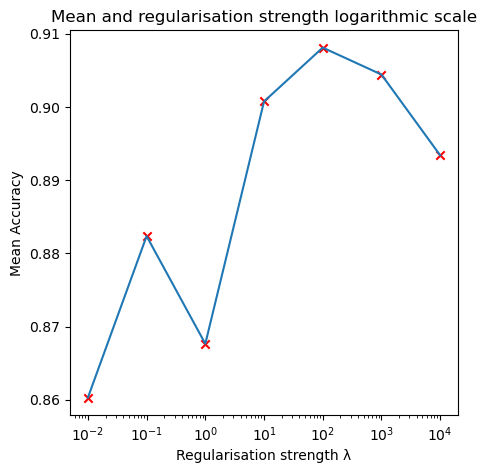

In [137]:
#Plotting MSE and regularisation strength on logarithmic scale

λ_range_limits = [1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]
penalties_limit = [cross_val_evaluate_svm(X_train, y_train_boolean_svm, num_folds, learning_rate = 1e-3, regul_strength = λ) for λ in λ_range_limits] 

plt.figure(figsize = (5,5))
plt.style.use('default')
plt.plot(λ_range_limits, penalties_limit)
plt.scatter(λ_range_limits, penalties_limit, marker = 'x', c = 'r')
plt.xscale('log')
plt.title('Mean and regularisation strength')
plt.ylabel('Mean Accuracy')
plt.xlabel('Regularisation strength λ')

As $\lambda\to\infty$, the accuracy falls from a peak of around 0.9 at $\lambda = 100$. Thus, when tuning the hyperparameter $\lambda$, values in the restricted range of $\lambda\in[0,100]$ will be considered.

Text(0.5, 0, 'Regularisation strength λ')

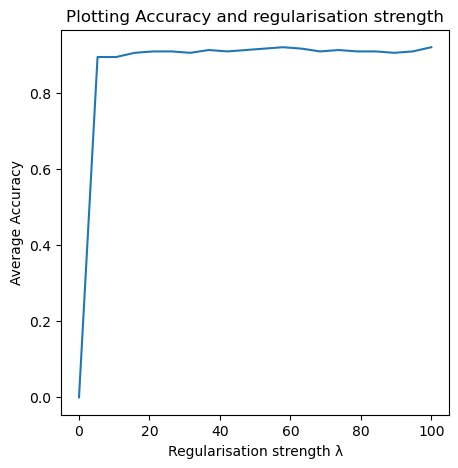

In [141]:
#Plotting MSE and regularisation strength
plt.figure(figsize = (5,5))
plt.plot(λ_range, grid_pred_params_svm)
plt.title('Plotting Accuracy and regularisation strength')
plt.ylabel('Average Accuracy')
plt.xlabel('Regularisation strength λ')

As $\lambda\to 0$, the accuracy falls to zero. This is in accord with the intuition that the regularisation parameter $\lambda$ controls the penalty for misclassification.

In [236]:
#grid search for optimal regularisation strength hyperparameter 
λ_range = np.linspace(0,100,20)
num_folds = 4

#converting categorical labels to 1,-1 values
y_train_boolean_svm = diabetes_boolean_svm(y_train)
y_test_boolean_svm = diabetes_boolean_svm(y_test)

grid_pred_params_svm = np.zeros(len(λ_range))

for i in range(len(λ_range)):
    
    #shuffle data
    N = len(y_train_boolean_svm) 
    p = np.random.permutation(N)
    X = X_train[p]
    y = y_train_boolean_svm[p]
    
    
    grid_pred_params_svm[i] = cross_val_evaluate_svm(X, y, num_folds, learning_rate = 1e-3, regul_strength = λ_range[i])

lambda_optimal_linear_svm = λ_range[grid_pred_params_svm.argmax()]

In [237]:
#Optimal lambda
print(f"Optimal penalty hyper-parameter for linear svm: {lambda_optimal_linear_svm}")

Optimal penalty hyper-parameter for linear svm: 89.47368421052633


#### 2.2.2

In [143]:
#Calculating angle between hyperplanes:
def cosine_angle_acute(n1, n2):
    #return: angle between vectors in degrees
    if (np.linalg.norm(n1) ==0 and np.linalg.norm(n2) == 0):
            return 0
    else:
        #normalise vectors
        n1 = n1/np.linalg.norm(n1)
        n2 = n2/np.linalg.norm(n2)
        
        return np.abs(np.dot(n1, n2))/(np.linalg.norm(n1) * np.linalg.norm(n2))

In [144]:
#computing angles between hyperplanes
λ_range = np.linspace(1,100,20)
num_folds = 4
cosines_angles = np.zeros((len(λ_range), len(λ_range)))
learning_rate = 1e-5

X_train = standardise(diabetes, diabetes)
y_train = diabetes_target
y_train_boolean_svm = diabetes_boolean_svm(y_train)


vectors = []

for i in range(len(λ_range)):
    N = len(y_train) 
    p = np.random.permutation(N)
    X = X_train[p]
    y = y_train_boolean_svm[p]
    

    vectors.append(sgd(X, y, max_iterations=1000,\
                 stop_criterion = 0.001, learning_rate=learning_rate, regul_strength=λ_range[i])[0])
    

In [145]:
for i in range(len(λ_range)):
    for j in range(len(λ_range)):
        if i !=j:
            cosines_angles[i,j] = cosine_angle_acute(vectors[i], vectors[j])
        else:
            cosines_angles[i,j] = 1

[Text(154.75, 0.5, 'Hardness $\\lambda$'),
 Text(0.5, 132.24999999999997, 'Hardness $\\lambda$')]

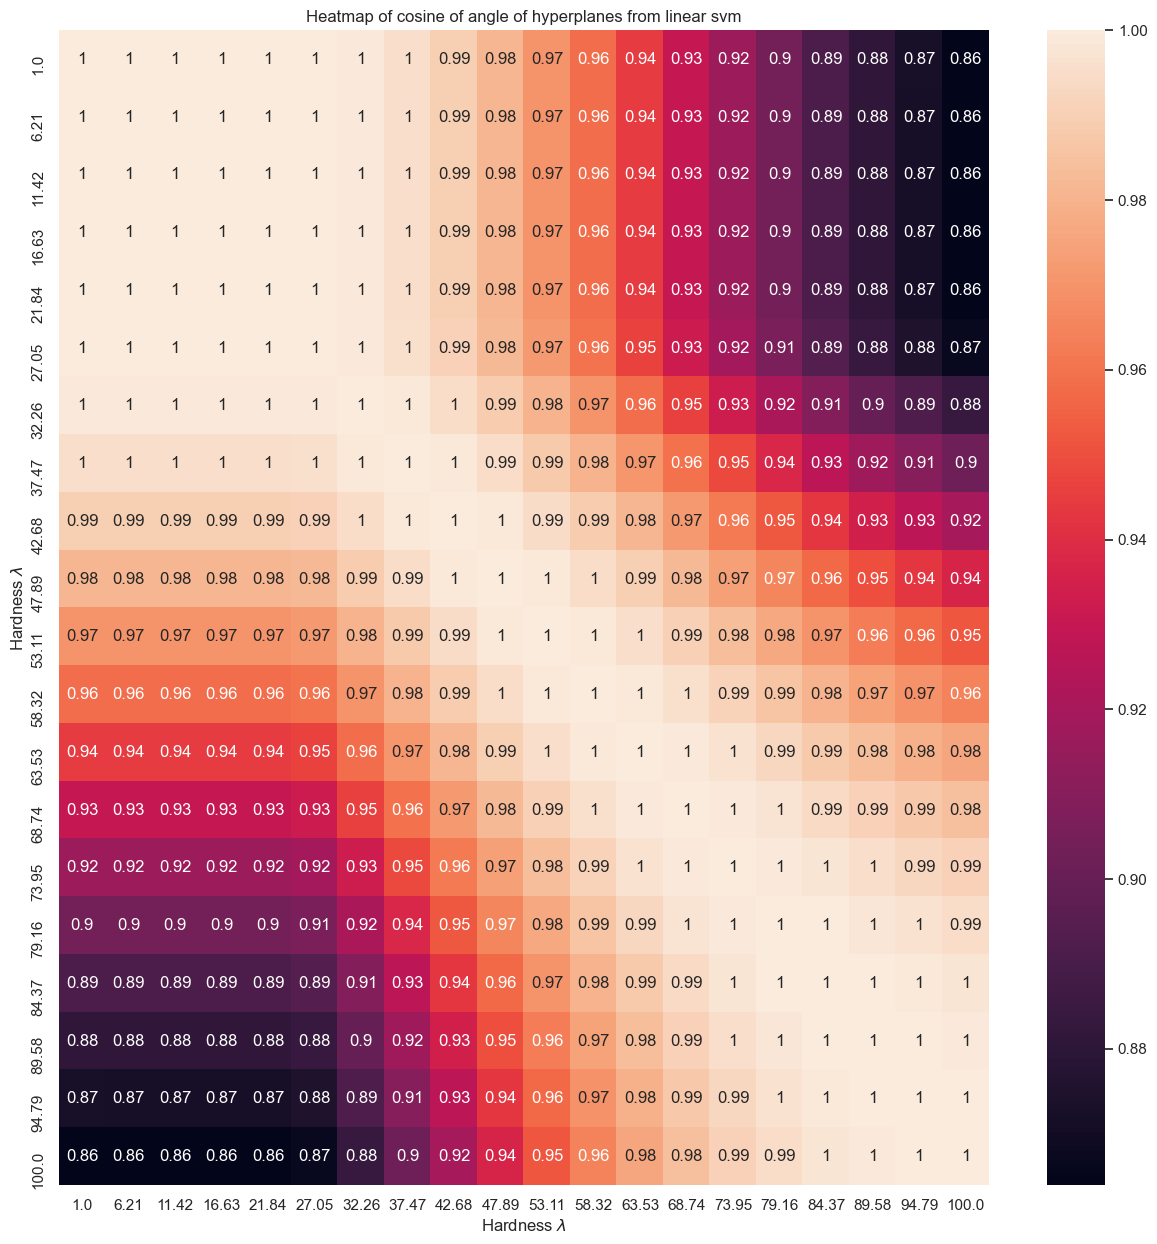

In [146]:
#plotting angles for pairs of strength hyperparameters
import seaborn as sns

labels = [round(element, 2) for element in λ_range]
df = pd.DataFrame(cosines_angles, columns = labels ,index = labels)

sns.set(rc={'figure.figsize':(15,15)})

ax = sns.heatmap(df, annot=True)
ax.set_title("Heatmap of cosine of angle of hyperplanes from linear svm")
ax.set(xlabel="Hardness $\lambda$", ylabel="Hardness $\lambda$")

Text(0, 0.5, 'Cosine of angle of hyperplanes')

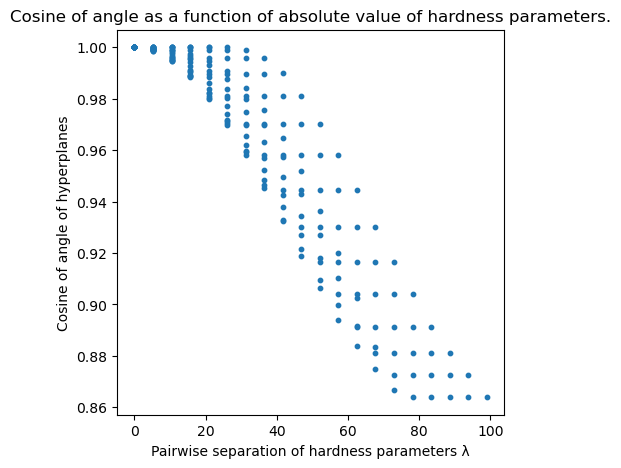

In [147]:
#Plotting the cosine of the angle of hyperplanes for different regulariastion strengths
angles = []
lambdas = []
for i in range(len(λ_range)):
    for j in range(len(λ_range)):
        if j>=i:
            lambdas.append(np.abs(λ_range[i]-λ_range[j]))
            angles.append(cosines_angles[i,j])
plt.figure(figsize = (5,5))     
plt.style.use('default')
plt.scatter(lambdas, angles, s = 10)
plt.title('Cosine of angle as a function of absolute value of hardness parameters.')
plt.xlabel('Pairwise separation of hardness parameters λ')
plt.ylabel('Cosine of angle of hyperplanes')

From the above scatter plot above and the heatmap, it seems that there is an inverse relationship between hardness parameter separation and hyperplane orientation.

#### 2.2.3

In [148]:
def precision_svm(y_test, y_pred):
    TP = np.sum(np.logical_and(y_pred == 1, y_test == 1))
    FN = len(np.where((y_pred == -1) & (y_test == 1))[0])
    FP = len(np.where((y_pred == 1) & (y_test == -1))[0])
    TN = len(np.where((y_pred == -1) & (y_test == -1))[0])
    N_val = TP+TN+FP+FN
    if (TP) == 0 & TP+FP == 0:
        return 0
    else: 
        return (TP)/(TP+FP)

In [149]:
def recall_svm(y_test, y_pred):
    TP = np.sum(np.logical_and(y_pred == 1, y_test == 1))
    FN = len(np.where((y_pred == -1) & (y_test == 1))[0])
    FP = len(np.where((y_pred == 1) & (y_test == -1))[0])
    TN = len(np.where((y_pred == -1) & (y_test == -1))[0])
    N_val = TP+TN+FP+FN
    if TP+FN == 0:
        return "No information"
    else: 
        return (TP)/(TP+FN)

In [150]:
def F_score_svm(y_test, y_pred):
    precision = precision_svm(y_test, y_pred) 
    recall = recall_svm(y_test, y_pred) 
    
    if (precision == 0 and recall == 0):
        return 0
    else:
        return 2*precision*recall/(precision+recall)

In [238]:
#Optimal regularisation strength value
λ_optimal_linear_svm = λ_range[grid_pred_params_svm.argmax()]

In [239]:
#call in data
X_train = standardise(diabetes, diabetes)
y_train = diabetes_target
X_test = standardise(diabetes, diabetes_test)
y_test = diabetes_test_target

#shuffle data
N = X_train.shape[0]
p = np.random.permutation(N)
X_train = X_train[p]
y_train = y_train[p]


In [240]:
#retrain SVM with optimal lambda

y_train_boolean_svm = diabetes_boolean_svm(y_train)
y_test_boolean_svm = diabetes_boolean_svm(y_test)

w_optimal, b_optimal = sgd(X_train, y_train_boolean_svm, max_iterations = 2000, stop_criterion=0.001,\
                learning_rate = 1e-2, regul_strength = λ_optimal_linear_svm)

y_pred = np.sign(X_test@w_optimal+b_optimal)
mean_accuracy_svm_linear = np.mean(y_pred == y_test_boolean_svm)

In [241]:
print(f"Out-of-sample mean accuracy for optimal strength parameter: {mean_accuracy_svm_linear}")
print(f"Out-of-sample Precision for optimal strength parameter: {precision_svm(y_test_boolean_svm, y_pred)}")
print(f"Out-of-sample F score for optimal strength parameter: {F_score_svm(y_test_boolean_svm, y_pred)}")

Out-of-sample mean accuracy for optimal strength parameter: 0.9316239316239316
Out-of-sample Precision for optimal strength parameter: 0.8333333333333334
Out-of-sample F score for optimal strength parameter: 0.7142857142857143


#### 2.2.4

In [242]:
def compute_cost_kernel(u, K, y, regul_strength=1e3,intercept=0):

    # Here I define the hinge cost with the kernel trick. 
    
    distances = 1 - (y)*(K@u + intercept) 
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge = regul_strength * np.sum(distances)

    # calculate cost
    return 0.5 * np.dot(u,K@u) + hinge

In the follwing, we implement a soft-margin kernelised SVM classifier with a non-linear kernel. Here, we use a sigmoid kernel:
$$k(x,y|\sigma) = \text{tanh}(\sigma(x\cdot y)+1)$$

In [243]:
def kernel_matrix(X1,X2, σ):  

    n1,m1 = X1.shape
    n2,m2 = X2.shape
    kernel = np.zeros((n1,n2))

    # Here we define a sigmoid Kernel #
    for i in range(n1):
        kernel[i,:] = np.tanh(σ*(X1[i]@X2.T)+1) 
        
    return kernel

The loss function for the kernelised svm model is now:

$$L(\mathbf{u},b) = \frac{1}{2}\mathbf{u}^{\rm{T}}\mathbf{K} \mathbf{u} + \lambda \sum_{i=1}^N  \max \Big\{0, 1-y^{(i)}(\mathbf{K}^{(i)}\mathbf{u} + b)\Big\},$$

where $\mathbf{K}$ is the matrix containing the kernel functions, i.e.
 $\mathbf{K}_{ij} = k(\mathbf{x}^{(i)},\mathbf{x}^{(i)})$. 
The cost is minimised using SGD. First, I create a function that computes the gradients:

In [244]:
def calculate_cost_gradient_kernel(u, K_batch, y_batch, regul_strength=1e3,intercept=0):

    """Calculate the ascent term for gradient descent with respect to the kernel svm cost function.
    Args:
      u: vector used in the kernel trick, with respect to which the cost is optimised
      
      y_batch: (np.array) batch of training labels used in stochastic gradient descent
      regul_strength: regularisation strength λ sed in the cost function.
      intercept: offset parameter that is learned by the model
      
    Returns:
      batch gradient

    """
    
    # if only one example is passed
    if type(y_batch) == np.float64 or type(y_batch) == np.int32:
        y_batch = np.asarray([y_batch])
        K_batch = np.asarray([K_batch])  # gives multidimensional array
    
    distance = 1 - (y_batch * (K_batch @ u + intercept)) 
    dw = np.zeros(len(u))
    dintercept = 0 
    
    # define the gradient with the hinge loss 
    for ind, d in enumerate(distance):
        if max(0, d)==0:
            di = K_batch@u
            dint = 0
        else:
            di = K_batch@u - (regul_strength * y_batch[ind] * K_batch[ind]) 
            dint =  - (regul_strength * y_batch[ind]) ## update intercept
        dw += di
        dintercept += dint

    return dw/len(y_batch), dintercept/len(y_batch)

In [245]:
def sgd_kernel(K, y, batch_size=32, max_iterations=4000, stop_criterion=0.001, learning_rate=1e-4, regul_strength=1e3, print_outcome=False):

    """Perform batch stochastic gradient descent to minimise the kernel svm cost function.
    Args:
      K: Gram matrix, in kernel trick 
      y: (np.array) training labels
      
      max_iterations: maximum number of iterations before the algorithm terminates
      stop_criterion: checks relative closeness of cost of kernel loss function and stops if adjacent values are within the tolerance
      regul_strength: regularisation strength λ sed in the cost function.
      print_outcome: (boolean)  
      
    Returns:
      u: vector used in the kernel trick, with respect to which the cost is optimised
      intercept: offset parameter that is learned by the model

    """
    
    
    # initialise zero u and intercept
    u = np.zeros(K.shape[1])
    intercept=0
    
    nth = 0
    # initialise starting cost as infinity
    prev_cost = np.inf
    
    # stochastic gradient descent
    indices = np.arange(len(y))
    for iteration in range(1, max_iterations):
        
        # shuffle to prevent repeating update cycles
        np.random.shuffle(indices)
        batch_idx = indices[:batch_size]
        K_b, y_b = K[batch_idx], y[batch_idx]
        
        
        for ki, yi in zip(K_b, y_b):
            ascent, ascent_intercept = calculate_cost_gradient_kernel(u, ki, yi, regul_strength, intercept)
            u = u - (learning_rate * ascent)/(iteration+1)
            intercept = intercept - (learning_rate * ascent_intercept)/(iteration+1)
        
        # convergence check on 2^n'th iteration
        if iteration==2**nth or iteration==max_iterations-1:
            # compute cost
            cost = compute_cost_kernel(u, K, y, regul_strength, intercept)
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))
            # stop criterion
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return u, intercept
            
            prev_cost = cost
            nth += 1
    
    return u, intercept

I now fix the hardness hyper-parameter $\lambda$ to $10$ and train the soft margin kernelised SVM classifier on the
dataset 'diabetes_samples.csv', considering values of the coefficient $\sigma$ in $[0.01, 0.1, 1, 2]$:

In [246]:
X_train = standardise(diabetes, diabetes)
y_train = diabetes_target
X_test = standardise(diabetes, diabetes_test)
y_test = diabetes_test_target
y_train_boolean_svm = diabetes_boolean_svm(y_train)
y_test_boolean_svm = diabetes_boolean_svm(y_test)

In [247]:
λ = 10

for sigma in [0.01, 0.1, 1, 2]:
    
    #shuffle data
    N = len(y_train) 
    p = np.random.permutation(N)
    X = X_train[p]
    y = y_train[p]
    y_train_boolean_svm = diabetes_boolean_svm(y)
    
    print('For sigma = ' + str(sigma))
    K_train = kernel_matrix(X, X, sigma)

    u,b = sgd_kernel(K_train, y_train_boolean_svm, batch_size=128, max_iterations=2000, stop_criterion=0.001, learning_rate=1e-3, regul_strength=λ)

    print("Inferred value of intercept: {}".format(b)+"\n")
    


For sigma = 0.01
Inferred value of intercept: -0.5820875511702004

For sigma = 0.1
Inferred value of intercept: -0.733642314186664

For sigma = 1
Inferred value of intercept: -1.2723279751535574

For sigma = 2
Inferred value of intercept: -1.2548521325683788



#### 2.2.5

Evaluating accuracy, precision and F-score of the kernelised SVM classifier from 2.2.4 on the test
set diabetes_test.csv for each value of $\sigma$ in $[0.01, 0.1, 1, 2]$:

In [248]:
λ = 10

y_test_boolean_svm = diabetes_boolean_svm(y_test)

for sigma in [0.01, 0.1, 1, 2]:
    
    #Shuffle data
    N = len(y_train) 
    p = np.random.permutation(N)
    X = X_train[p]
    y = y_train[p]
    y_train_boolean_svm = diabetes_boolean_svm(y)
    
    print('For sigma = ' + str(sigma))
    K_train = kernel_matrix(X,X, sigma)

    u,b = sgd_kernel(K_train, y_train_boolean_svm, batch_size=32, max_iterations=2000, stop_criterion=0.001, learning_rate=1e-2, regul_strength=λ, print_outcome=False)

    print("Inferred value of intercept: {}".format(b))
    
    K_test = kernel_matrix(X_test,X, sigma)
        
    y_pred = np.sign(K_test@u + b) 
    
    mean_accuracy_svm_kernel = np.mean(y_pred == y_test_boolean_svm)
    
    def precision_kernel_svm(y_test, y_pred):
        TP = np.sum(np.logical_and(y_pred == 1, y_test == 1))
        FN = len(np.where((y_pred == -1) & (y_test == 1))[0])
        FP = len(np.where((y_pred == 1) & (y_test == -1))[0])
        TN = len(np.where((y_pred == -1) & (y_test == -1))[0])
        N_val = TP+TN+FP+FN
        if TP+FP == 0:
            return "No information; no true positives and false positives"
        else: 
            return (TP)/(TP+FP)
    
    def recall_kernel_svm(y_test, y_pred):
        TP = np.sum(np.logical_and(y_pred == 1, y_test == 1))
        FN = len(np.where((y_pred == -1) & (y_test == 1))[0])
        FP = len(np.where((y_pred == 1) & (y_test == -1))[0])
        TN = len(np.where((y_pred == -1) & (y_test == -1))[0])
        N_val = TP+TN+FP+FN
        if TP+FN == 0:
            return "No information; no true positives and false negatives"
        else: 
            return (TP)/(TP+FN)
    
    def Fscore_kernel_svm(y_test, y_pred):
        import math
        precision = precision_kernel_svm(y_test, y_pred)
        
        recall = recall_kernel_svm(y_test, y_pred)
        
        if type(recall) ==  str or  type(precision) ==  str:
            return "No information"
        else: 
            return 2*precision*recall/(precision+recall)


    print("Accuracy on test set: {}".format(mean_accuracy_svm_kernel))
    print("Precision on test set: {}".format(precision_kernel_svm(y_test_boolean_svm, y_pred)))
    print("F_score on test set: {}".format(Fscore_kernel_svm(y_test_boolean_svm, y_pred))+"\n")


For sigma = 0.01
Inferred value of intercept: -1.0294928507202348
Accuracy on test set: 0.8632478632478633
Precision on test set: No information; no true positives and false positives
F_score on test set: No information

For sigma = 0.1
Inferred value of intercept: -1.3100815236956953
Accuracy on test set: 0.9230769230769231
Precision on test set: 0.8181818181818182
F_score on test set: 0.6666666666666666

For sigma = 1
Inferred value of intercept: -3.0598671323714854
Accuracy on test set: 0.8632478632478633
Precision on test set: 0.5
F_score on test set: 0.5789473684210527

For sigma = 2
Inferred value of intercept: -2.4001915998435157
Accuracy on test set: 0.8888888888888888
Precision on test set: 0.5789473684210527
F_score on test set: 0.6285714285714286



By observing the above scores, one readily observes that for $\sigma = 0.01$, we get no precision and F scores. This means that the model had no true positives and false positives. That is, it only predicted 'non-diabetic' for all the patients. The fact that the accuracy was good, namely $86\%$ can be attributed to the fact that the data is unbalanced in favour of the 'non-diabetic'label, which is more prevalent, at precisely the rate the accuracy gives.

One can draw two conclusions: either the kernel model for $\sigma$ above generalises poorly to unknown data, that is, it is $\textbf{not robust}$ regarding classification of the 'diabetes' label; alternatively one can argue that the test set is too small (117 records) for statistically significant phenomena to be observed.

Now, for $\sigma = 0.1, 1,2$, model performance improves relative to the previous values considered, and peak performance is attained in all metrics listed for $\sigma = 0.1$. The out-of-sample F scores are above $60\%$, which are reasonable scores. The precision scores, being initially high at around $0.8$ for $\sigma = 0.1,$, and then fall off to around $\sim0.6$ mean that the for $\sigma = 1,2$, the kernelised svm model with signoid kernel generalises satisfactorily to the test set with reasonable true positive rates, and similar recall and precision (due to the F score), which are desirable for rare-event classification. A high accuracy suggests a relatively higher true negative rate, which is not as optimal for this classification problem though.

Finally, note that the above comparison was made with an adaptive learning rate initialised at $10^{-2}$.

#### Comparsion between linear and kernelised svm:

$$\begin{aligned}
& 
&\begin{array}{cc}
\hline \hline  &\text { Linearised svm}  & \text{Kernel svm with } \sigma = 0.1 \\
\hline \text{Out-of-sample Accuracy} & 0.9316239316239316& 0.9230769230769231& \\
\hline \text{Out-of-sample Precision} & 0.8333333333333334 &  0.8181818181818182 & \\
\hline \text{Out-of-sample F score} & 0.7142857142857143 & 0.6666666666666666 &\\
\hline
\end{array}
\end{aligned}\\
\text {Table 2.1. Comparing linearised and sigmoid kernel svm model performance}
$$

We observe from table $2.1$ that in all the scores, the sigmoid svm model performs better than the linear svm. 

As an extension of the above models, one introduce a different kernel function of the form
$$
K(\boldsymbol x_i, \boldsymbol x_j) = \displaystyle \sum_{\alpha} \lambda_{j}\cdot K_{\alpha}(\boldsymbol x_i, \boldsymbol x_j; \theta_{\alpha})
$$
where the $K_j$ are kernel functions of various types, such as linear, polynomial or even Gaussian <a name="ref-1"/>[Banjoko, 2019].

Note that each kernel function $K_{\alpha}$ can have its own hyperparameters $\theta_{\alpha}$ that can be tuned as well. For instance, the Gaussian kernel

$$K(\boldsymbol x_i, \boldsymbol x_j) = \exp\left(-\gamma||\boldsymbol x_i - \boldsymbol x_j||^2\right), \quad \gamma>0$$

can be used if the separation of labels on the trainging data is suspected to be radial in nature.

Furthermore, one can then treat the $\lambda_j$ as hyperparameters to be tuned by performing a grid/random search. However, a potential drawback of this approach is that it will likely be computaionally expensive. Thus care has to be taken to study the geometry of the data to make appropriate choices of kernel functions. Otherwise, model overfitting may occur if no considerations of the above kind are made.

It does not seem that a discernible geometric separation (linear in this case) exists in the data points of different labels that would enable satisfactory classification of the minority class by a kernelised svm model. 

The obstacle seems to be the selection of features at hand. Thus, to improve model performance, one must inspecct the data set more carefuly and try and determine which features are the best predictors of the minority class and remove redundant features. Thus, we do a pairplot of the training data that compare feature valeus of diabetic (red) and non-diabetic people (green).

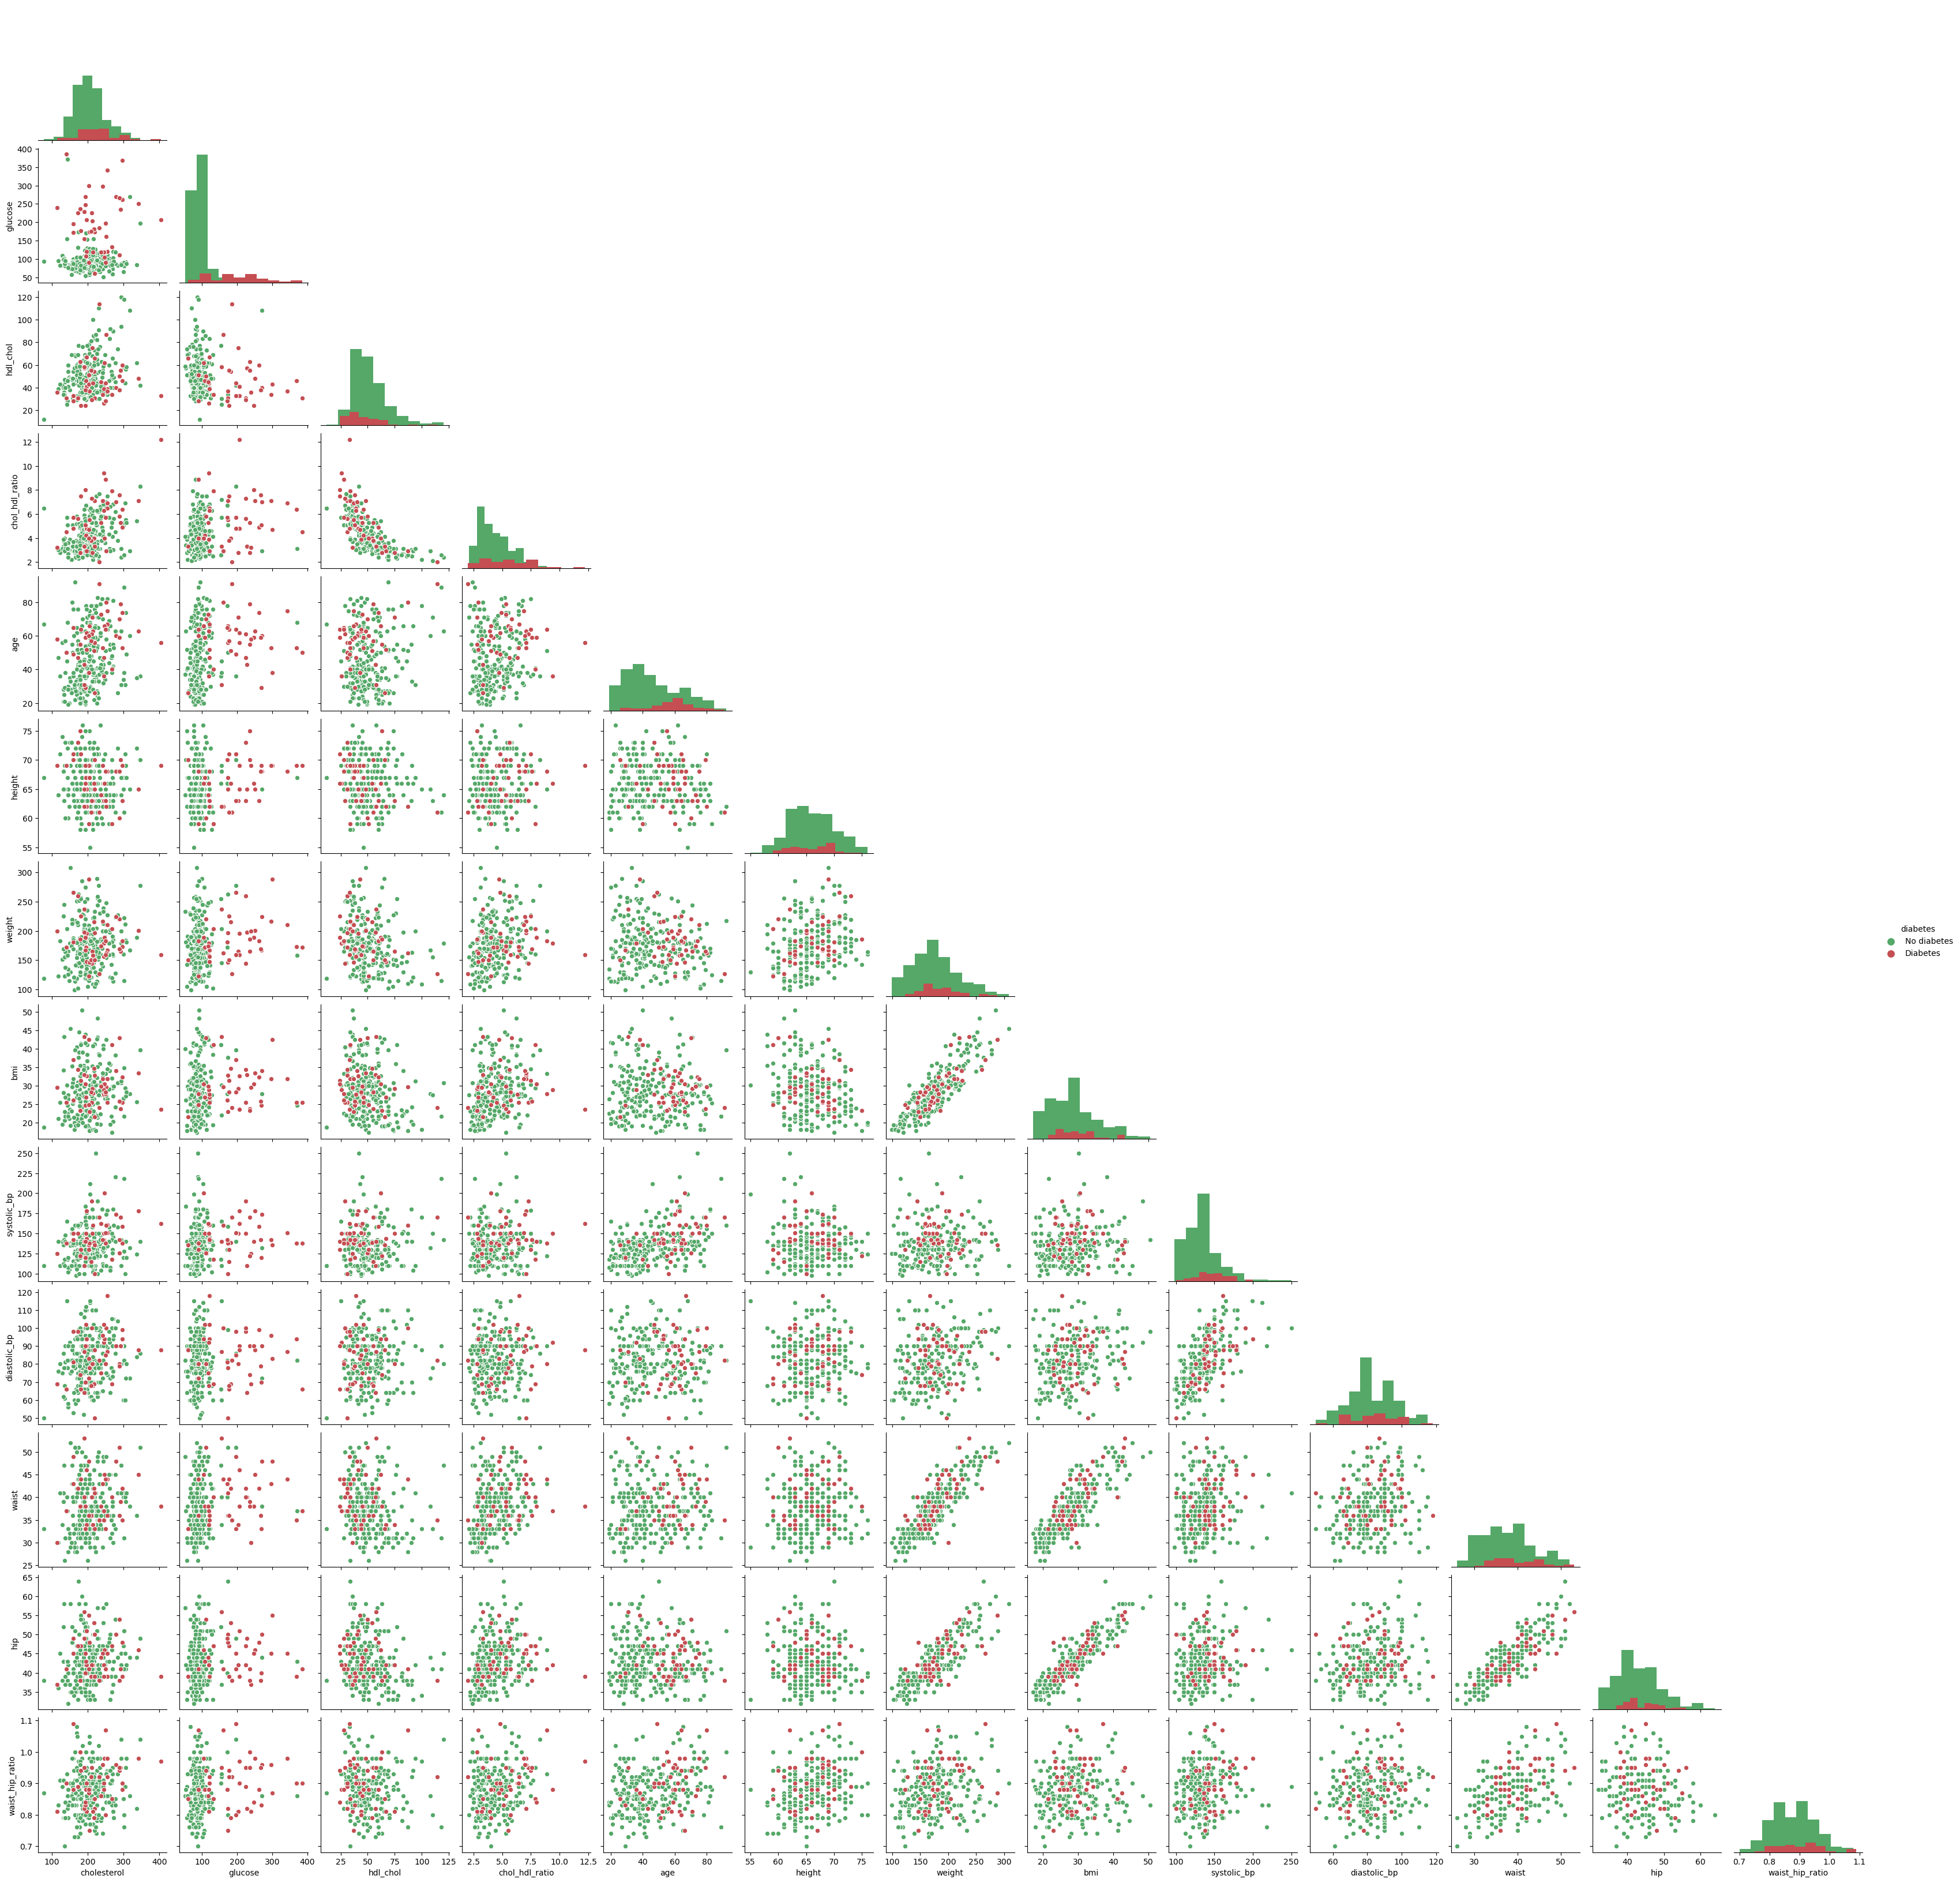

In [162]:
#pairplot for features in data with diabetic and non-diabetic classes treated separately
diabetes_features = diabetes_data.columns[1:]
df = diabetes_data[diabetes_features]
g = sns.pairplot(df, hue="diabetes", palette=['g', 'r'], diag_kind="hist", corner=True)
for lh in g._legend.legendHandles: 
    lh._sizes = [100] 

By observing the pair plots above, all the predictor features seem to be localised in space and one can see that the glucose levels display the highest degree of linear separability between diabetic (red) and non-diabetic patients (green). This suggests that for the training data given, glucose is the dominant predictor of diabetes in patients. More broadly, this means that not al lfeatures are as equally good predictors of being in the minority class, namely having diabetes.

Thus, to improve model performance, one can do greedy feature selection. This should reduce model variance, and improve precision and F score values due to better true positive rates. 

## References
Banjoko, A. W., et al. "Weighted support vector machine algorithm for efficient classification and prediction of binary response data." 
Journal of Physics: Conference Series. Vol. 1366. No. 1. IOP Publishing, 2019.

Hastie, Trevor, et al. The elements of statistical learning: data mining, inference, and prediction. Vol. 2. New York: springer, 2009.

M. Barahona, P. Thomas, P. Bravi. MATH60026 Methods for Data Sciences Lecture Notes.